## Table of contents:

<ol>
    <li>Algorithm</li>
        <ul>
            <li><a href='#overview'>Overview</a></li>
            <li><a href='#code'>Module Implementation</a></li>
        </ul>
    <li><a href='#data'>Data</a></li>
    <li><a href='#demo'>DEMO</a></li>
    <li>Findings and Conclusions
        <ul>
        <li><a href='#model'>Effect of model choices</a></li>
        <li><a href='#fading'>Effect of exponentially smoothing the error</a></li>
        <li><a href='#window'>Effect of sliding window strategy to update the error</a> TODO</li>
        <li><a href='#hidden'>Drift in hidden variables - detection</a></li>
        </ul>
    </li>
</ol>

<a id='overview'></a>
## 1.1 - SPC Overview

#### Theoretical Refresher from Change Detection class (05/3/2024)
_Gama, et. al, Learning with Drift Detection, Lecture Notes in Computer
Science 3171, Springer._

- Suppose a sequence of examples in the form $< \overline{xi}, yi >$
- The current decision model classifies each example in the sequence
- In the 0-1 loss function, predictions are either True or False
- The predictions of the learning algorithm are sequences: $True$,$False$,$True$,$False$,$True$,$False$,$True$,$True$,$True$,$False$,...
- The Error is a random variable from Bernoulli trials
- The Binomial distribution gives the general form of the probability of observing a $False$: $p_i = \frac{{\#F}}{{i}}$ and $s_i = \sqrt{\frac{{p_i(1 - p_i)}}{{i}}}$, where i is the number of trials

The Statistical Process Control algorithm maintains two registers:
- $P_{min}$ and $S_{min}$ such that $P_{min} + S_{min} = min(p_i + s_i)$. The minimum error rate taking into account the variance of the estimator

At example $j$, the error of the learning algorithm will be:
- In-control if $p_j + s_j < P_{min} + 2 ∗ S_{min}$
- Out-control if $p_j + s_j \geq P_{min} + 3 ∗ S_{min}$
- Warning Level if $P_{min} + 3 ∗ S_{min} \geq p_j + s_j > P_{min} + 2 ∗ S_{min}$

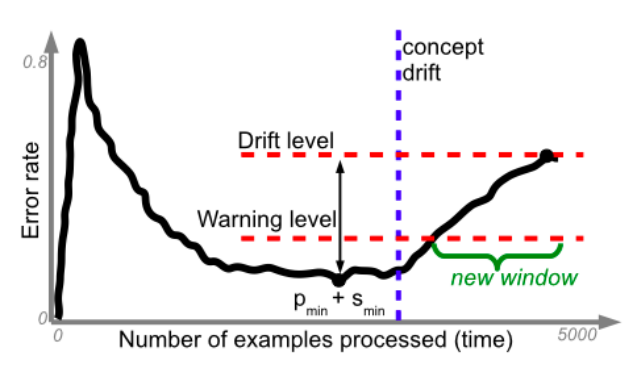

- At example $j$ the current decision model classifies the example 
- Compute the error and variance: $p_j$ and $s_j$
- If the error is
    - In-control: The current model is updated. Incorporate the example in the decision model
    - Warning: Maintain the current model. First Time: the lower limit of the window is: $L_{warning} = j$
    - Out-Control: Re-learn a new model using as training set the set of examples $[L_{warning} , j]$

<a id='code'></a>
## 1.2- SPC Module Implementation

The SPC module implements the detector class (SPCAlgorithm). Within this class, the following methods are defined:
- **\_\_init__()**: class initialization. It requires a function that initializes a river compatible estimator (ML model) to be given by the user.
- **_update()** : receives the ML model result, calculates the current error rate (p) and variance (s) and updates the Pmin and Smin if needed. Then it checks and returns the process status (In-control, Warning, Out-control).
- **_exponential_smoothing_update()** : similar to _update() but using an exponential smooting strategy for the error rate calculation.
- **_sliding_window_update()** : similar to _update() but using a sliding window strategy for the error rate calculation.
- **_model_train()** : trains the ML model with the last iput or with a batch of inputs if re-training is needed.
- **_reset_model()** : re-initializes the ML model if re-training is needed, by calling the estimator initialization function given by the user..
- **model_control()** : wrapper function that calls _reset_model() and _train_model(), depending on the status returned by _update(). This function is intended to be called by the user from outside the module.
- **process_plot()** : generates plots containing the process control results (error rate, including indicators for warning and drift levels, and process state). This function is intended to be called by the user from outside the module.
- **live_error()** : generates and continuously updates a figure with the error and detections. This function is intended to be called by the user from outside the module.
- **error_analysis_plot()** : plot the errors for SPC error, model with SPC error, baseline model error (without SPC). It also generates a second plot with the SPC process levels. This function is intended to be called by the user from outside the module.


[Click to open SPC module](./SPC_module/SPC.py)

<a id='data'></a>
## 2 - Data

Based on the SEA Concepts:
- 120.000 examples
- 3 attributes (only 2 are relevant)
    - numeric between 0 and 10
- 2 classes
- 4 concepts
    - each repeated twice
    - defined by the sum of the 2 rlevant attributes
    - if sum > threshold, then class = 0
    - concept thresholds: 8, 9, 7, 10
- noise: 10%

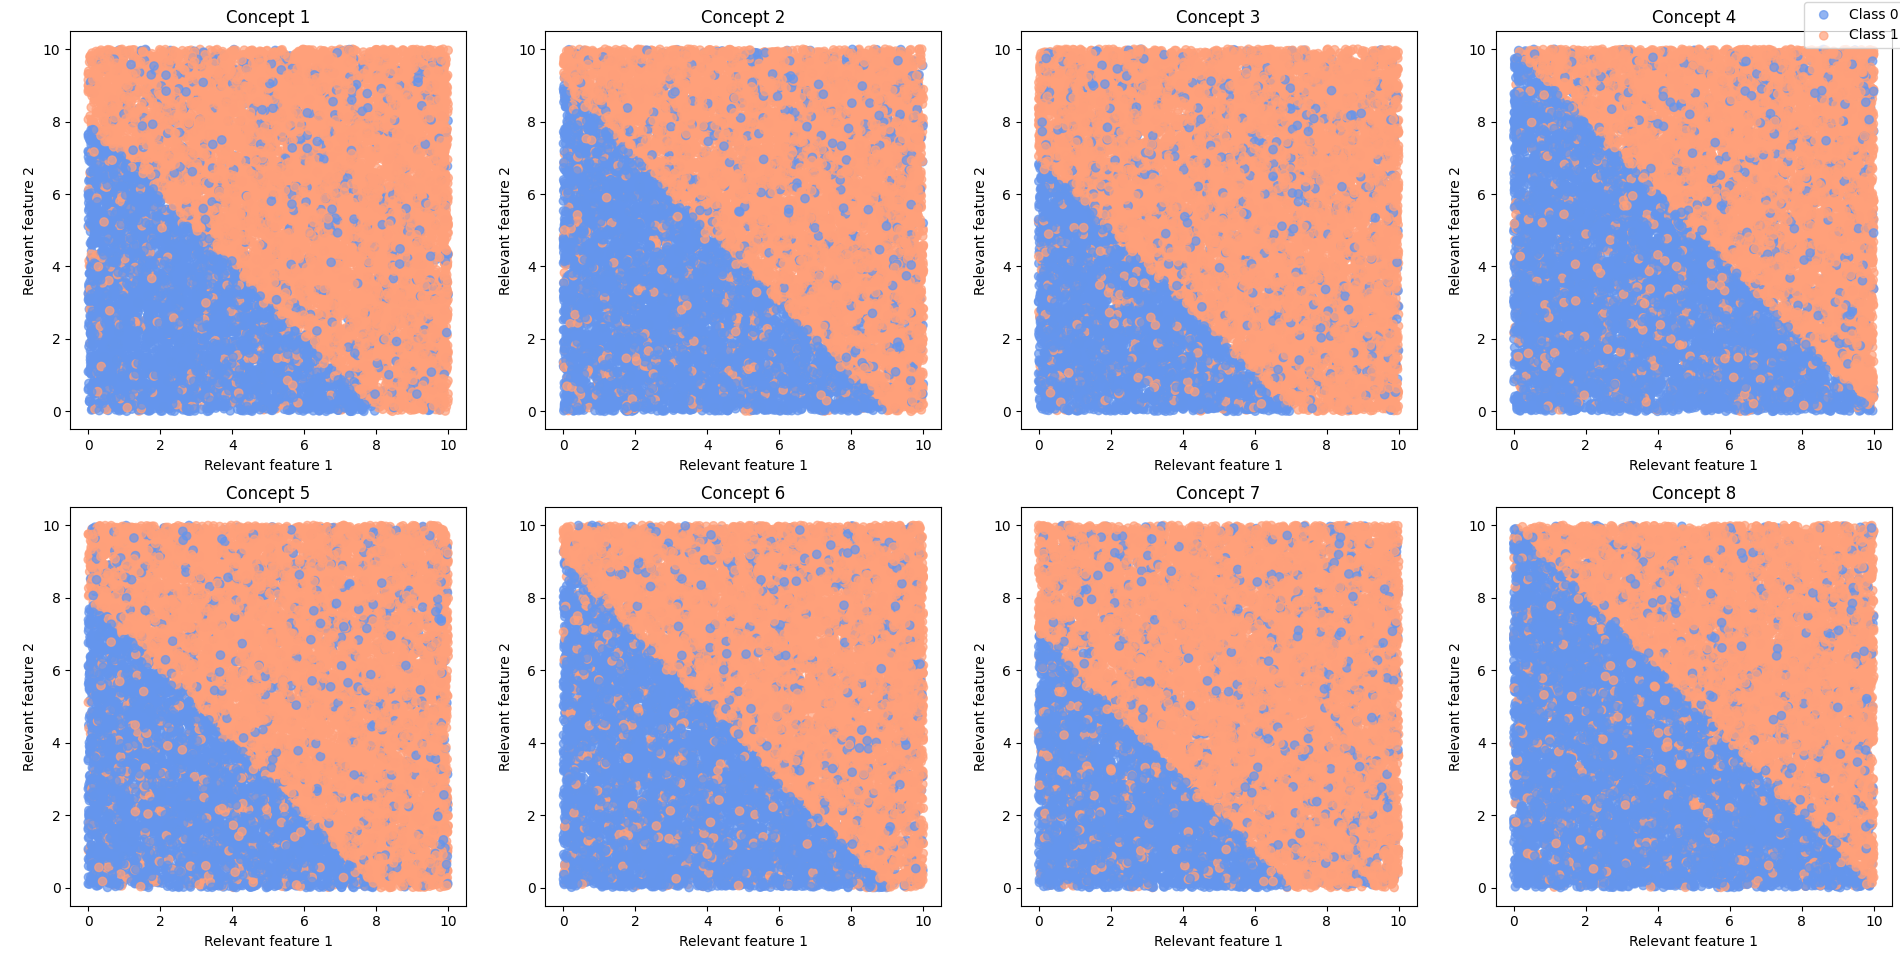

[Click to open data generation script](./SEAconcepts.py)

In [24]:
import os
import pandas as pd

# import data
PATH = os.path.dirname(os.path.abspath('__file__'))
data_stream = pd.read_csv(f"{PATH}/data/SEAconcepts.csv")

<a id='demo'></a>
## DEMO:

#### How to Use:
- Download the SPC_module folder from https://github.com/miguelFigSilva/dsm_SPC
- Install the requirements (pip install -r SPC_module/requirements.txt)
- Import the required packages (including the SPC module)
- Create a function that initializes an estimator (machine learning model) of the user's choice. This estimator learning phase is the process we want to control using the SPC module.
    - Remark: The user shall ensure that the chosen estimator is compatible with the river package. 
    - Hint: there are available functions that help with this, e.g. river.compat.convert_sklearn_to_river().
- Initialize the SPC detector

Once initialized, the SPC algorithm can run on the data stream. It will monitor the learning process of the chosen estimator and detect any anomalies or drifts.
The SPC algorithm provides real-time feedback on the status of the process. It categorizes the process into three states:
- Normal: The process is operating within expected parameters.
- Warning: Deviation detected, indicating a potential issue.
- Out of Control: Significant deviation detected, requiring intervention.

The user may use the algorithm’s output within the control loop.

- Implement the control loop
    - Run the algorithm
    - Monitor the detector outputs
    - Visualize results using the provided plotting functions

In [2]:
from SPC_module.SPC import SPCAlgorithm, live_error, error_analysis_plot
from river import compat
from river import preprocessing
import warnings
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import neural_network

warnings.filterwarnings("ignore")

In [3]:
def control_loop(spc_detector, report=500, exponential=False, alpha=0.9, sliding_window=False, window_size=100):
    warn = -1
    retrain = -1
    E, N, screen, fig = [0], [0], None, None
    drifts = []

    for i in range(data_stream.shape[0]):
        status, y, y_pred = spc_detector.model_control(data_stream, i, exponential=exponential, alpha=alpha, sliding_window=sliding_window, window_size=window_size)
        N.append(N[-1] + 1)
        E.append(E[-1] + (y!=y_pred)+0)

        if status == 'Out-control': drifts.append(i)

        if (i+1)%report == 0: 
            print(f'Error after {i+1} samples = {np.round(100*E[-1]/N[-1], 2)}%')
            E, N = np.array(E), np.array(N)
            screen, fig = live_error(E[np.arange(report, i+2, report)]/N[np.arange(report, i+2, report)],
                                     N[np.arange(report, i+2, report)], drifts=drifts, size=50, screen=screen, fig=fig)
            E, N = list(E), list(N)

        if status == 'Warning Level' and warn == -1 and i!=0:
            warn = i
            retrain = -1
        elif status == 'Out-control' and retrain == -1 and i!=0:
            retrain = i
            warn = -1
        else:
            warn = -1
            retrain = -1


    # Plotting
    time.sleep(2)
    screen.close()
    spc_detector.process_plot()

    return spc_detector, E, N

In [4]:
def init_estimator_GaussianNB():
    model = compat.convert_sklearn_to_river(
        estimator=naive_bayes.GaussianNB(),
        classes=[False, True]
    )
    return model

In [5]:
def baseline_learning(model, data_stream):
    baseline, e = [], 0
    for i in range(data_stream.shape[0]):
        y_pred = model.predict_one(data_stream.iloc[i, :-1])
        model.learn_one(data_stream.iloc[i, :-1], data_stream.iloc[i, -1])
        e += (data_stream.iloc[i, -1] != y_pred)+0
        baseline.append(e/(i+1))
    return baseline

In [6]:
def time_diff_plot(spc_detector):
    detected = np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2])
    real = 15000*np.array(np.arange(1,8))

    if len(detected) == len(real):
        fig = plt.figure(figsize=(12, 3))
        plt.bar([0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0], detected-real, width=0.3)
        plt.xticks(ticks=[0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0],
                labels=['C1 -> C2', 'C2 -> C3', 'C3 -> C4', 'C4 -> C1', 'C1 -> C2', 'C2 -> C3', 'C3 -> C4'])
        plt.ylabel('Number of examples')
        plt.title(f'Time difference between real and detected drift (avg = {int(np.mean(detected-real))})')
    else:
        print("WARNING: Number of detected changes different from number of real changes! Time comparison not possible.")

In [7]:
# IMP - juntar ao outro ciclo para fazer ao mesmo tempo
# -> isso vai afetar muito o tempo de processamento e vai dar a ideia errada que o SPC está muito mais lento do que na realidade está. Acho boa ideia fazer separado
def baseline_learning(model, data_stream):
    baseline, e = [], 0
    for i in range(data_stream.shape[0]):
        y_pred = model.predict_one(data_stream.iloc[i, :-1])
        model.learn_one(data_stream.iloc[i, :-1], data_stream.iloc[i, -1])
        e += (data_stream.iloc[i, -1] != y_pred)+0
        baseline.append(e/(i+1))
    return baseline

In [8]:
def time_diff_plot(spc_detector):
    detected = np.array([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2])
    real = 15000*np.array(np.arange(1,8))

    if len(detected) == len(real):
        fig = plt.figure(figsize=(12, 3))
        plt.bar([0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0], detected-real, width=0.3)
        plt.xticks(ticks=[0.3, 0.75, 1.2, 1.65, 2.1, 2.55, 3.0],
                labels=['C1 -> C2', 'C2 -> C3', 'C3 -> C4', 'C4 -> C1', 'C1 -> C2', 'C2 -> C3', 'C3 -> C4'])
        plt.ylabel('Number of examples')
        plt.title(f'Time difference between real and detected drift (avg = {int(np.mean(detected-real))})')
    else:
        print("WARNING: Number of detected changes different from number of real changes! Time comparison not possible.")

Error after 2000 samples = 13.55%
Error after 4000 samples = 12.52%
Error after 6000 samples = 12.72%
Error after 8000 samples = 12.32%
Error after 10000 samples = 12.36%
Error after 12000 samples = 12.51%
Error after 14000 samples = 12.24%
Error after 16000 samples = 12.45%
Num examples post retraining =  673
Num negatives post retraining =  93
Error after 18000 samples = 12.57%
Error after 20000 samples = 12.58%
Error after 22000 samples = 12.49%
Error after 24000 samples = 12.45%
Error after 26000 samples = 12.48%
Error after 28000 samples = 12.45%
Error after 30000 samples = 12.46%
Num examples post retraining =  1130
Num negatives post retraining =  133
Error after 32000 samples = 12.86%
Error after 34000 samples = 12.79%
Error after 36000 samples = 12.76%
Error after 38000 samples = 12.75%
Error after 40000 samples = 12.78%
Error after 42000 samples = 12.74%
Error after 44000 samples = 12.73%
Error after 46000 samples = 13.14%
Num examples post retraining =  921
Num negatives pos

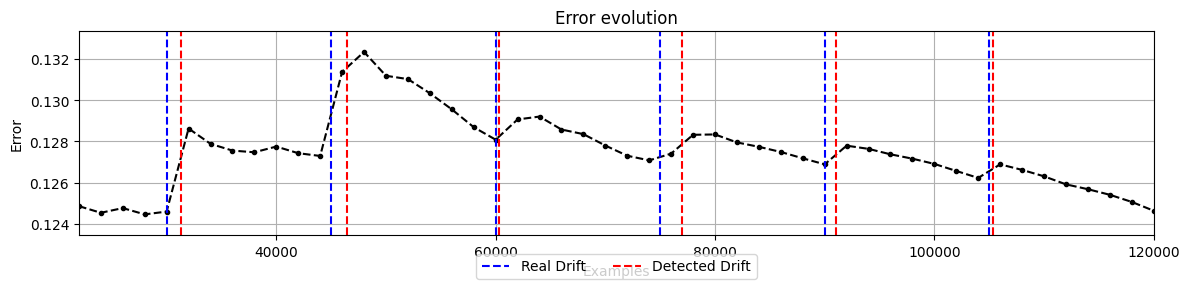

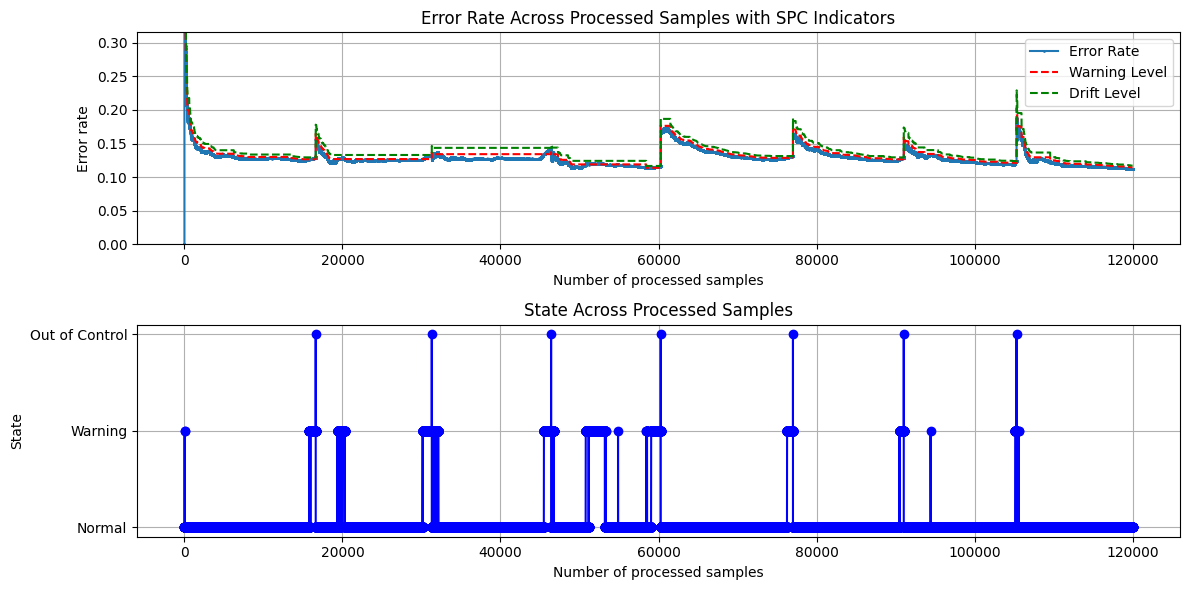

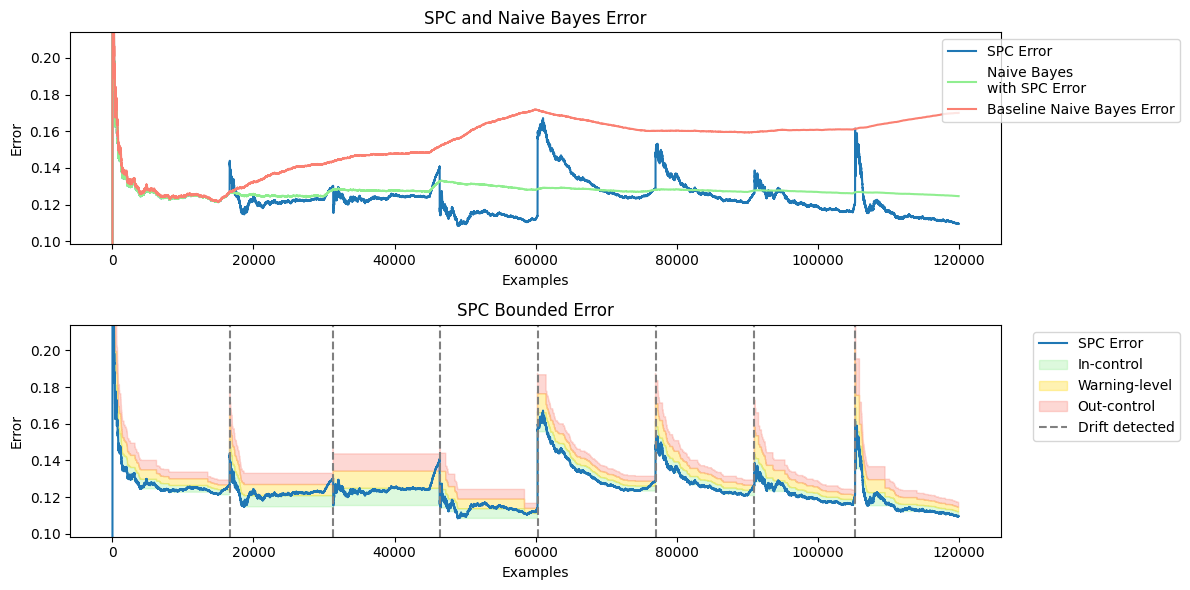

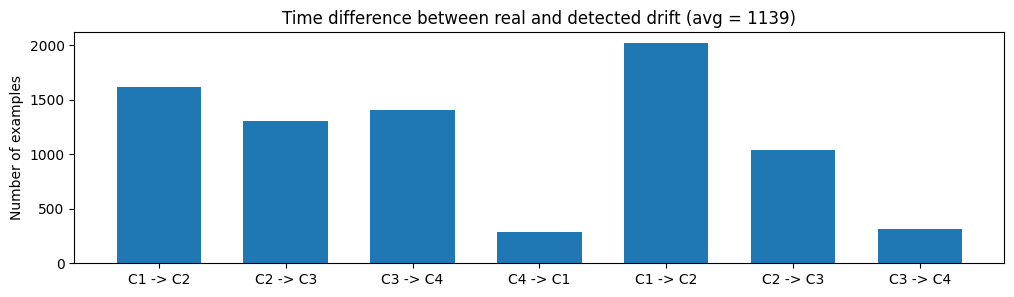

In [9]:
# load Naive Bayes baseline error
baseline = np.load('StandardNaiveBayesError.npy')

spc_detector = SPCAlgorithm(init_estimator_GaussianNB)

spc_detector, E, N = control_loop(spc_detector, report=2000)

model = init_estimator_GaussianNB()
#baseline = baseline_learning(model, data_stream)
error_analysis_plot(spc_detector, baseline, N, E, "Naive Bayes")

# save baseline error for latter use
np.save('StandardNaiveBayesError.npy', np.array(baseline))

time_diff_plot(spc_detector)

## 4 - Findings and Conclusions

<a id='model'></a>
### 4.1 - Effect of model choices:

#### 4.1.1 - Naive Bayes with standard scaling:

In [10]:
def init_estimator_StandardizedGaussianNB():
    model = preprocessing.StandardScaler()
    model |= compat.convert_sklearn_to_river(
        estimator=naive_bayes.GaussianNB(),
        classes=[False, True]
    )
    return model

Error after 2000 samples = 13.85%
Error after 4000 samples = 12.55%
Error after 6000 samples = 12.77%
Error after 8000 samples = 12.3%
Error after 10000 samples = 12.33%
Error after 12000 samples = 12.48%
Error after 14000 samples = 12.21%
Error after 16000 samples = 12.42%
Num examples post retraining =  668
Num negatives post retraining =  93
Error after 18000 samples = 12.53%
Error after 20000 samples = 12.44%
Error after 22000 samples = 12.35%
Error after 24000 samples = 12.3%
Error after 26000 samples = 12.32%
Error after 28000 samples = 12.29%
Error after 30000 samples = 12.3%
Num examples post retraining =  762
Num negatives post retraining =  100
Error after 32000 samples = 12.62%
Error after 34000 samples = 12.58%
Error after 36000 samples = 12.55%
Error after 38000 samples = 12.56%
Error after 40000 samples = 12.6%
Error after 42000 samples = 12.57%
Error after 44000 samples = 12.57%
Num examples post retraining =  342
Num negatives post retraining =  42
Error after 46000 sam

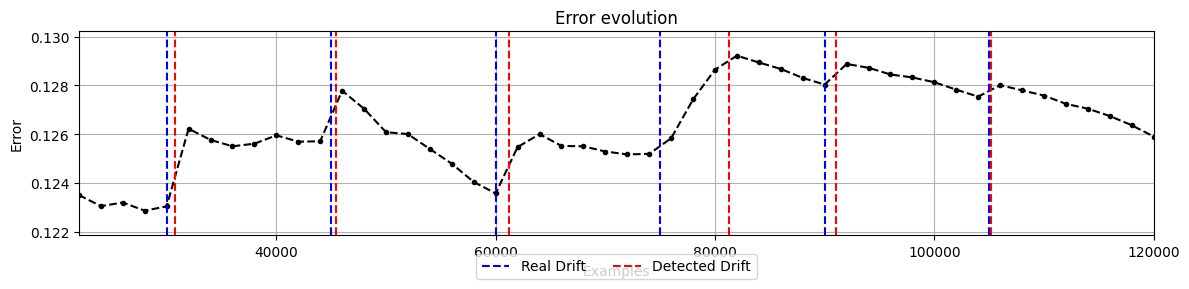

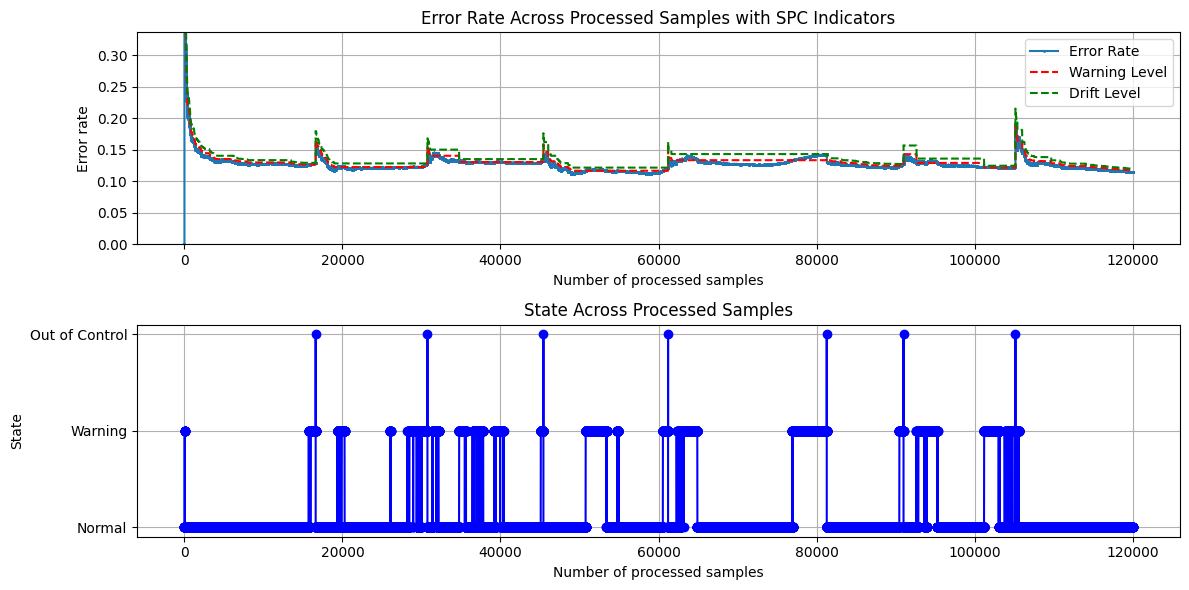

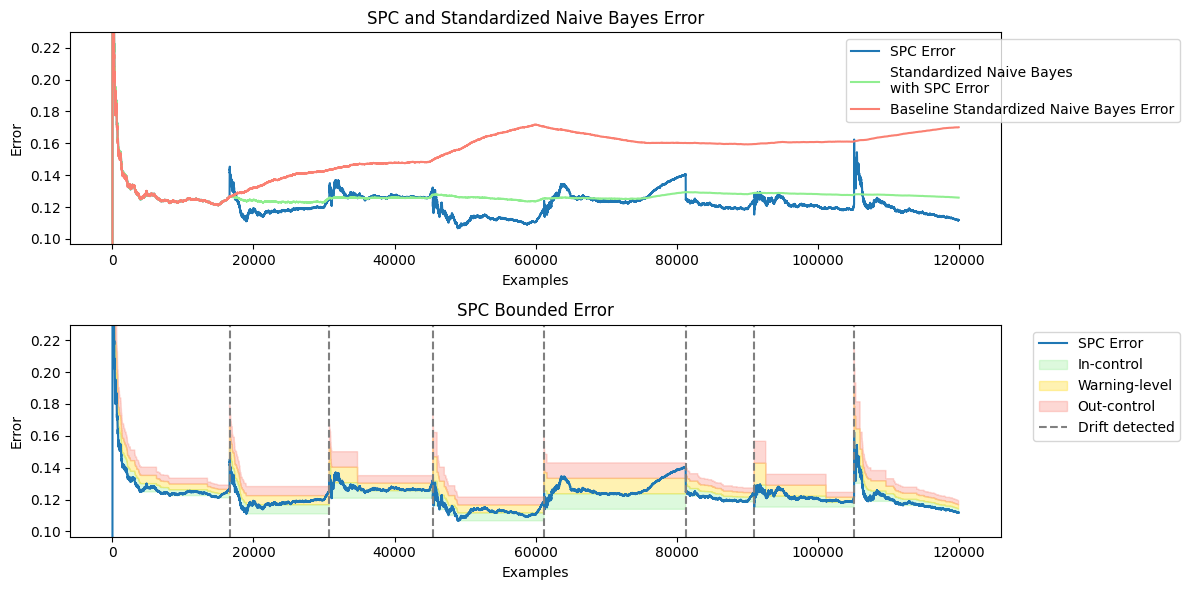

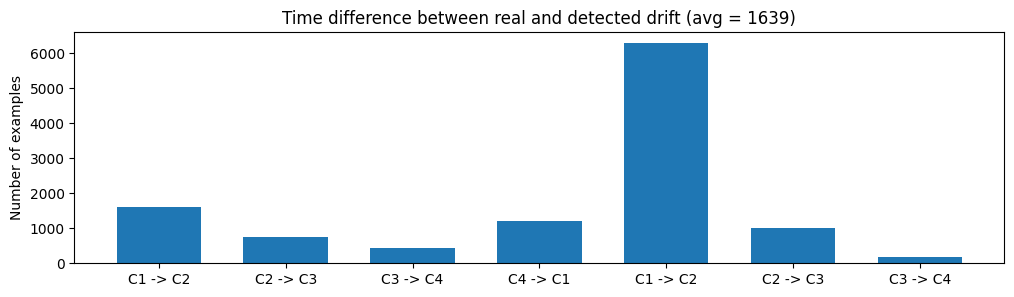

In [11]:
model = init_estimator_StandardizedGaussianNB()

spc_detector = SPCAlgorithm(init_estimator_StandardizedGaussianNB)
spc_detector, E, N = control_loop(spc_detector, report=2000)

baseline = baseline_learning(model, data_stream)
error_analysis_plot(spc_detector, baseline, N, E, "Standardized Naive Bayes")

time_diff_plot(spc_detector)

#### 4.1.2 - Logistic Regression Classifier:

In [12]:
def init_estimator_SGDClassifier():
    model = preprocessing.StandardScaler()
    model |= compat.convert_sklearn_to_river(
    estimator=linear_model.SGDClassifier(
        loss='log_loss',                   # 'log_loss' gives LOGISTIC REGRESSION. Uncomment to use it.
        #loss='hinge',                     # 'hinge' gives a LINEAR SVM. Uncomment to use it.
        #loss='perceptron',                # 'perceptron' is the linear loss used by the PERCEPTRON algorithm. Uncomment to use it.
        #loss='modified_huber',            # 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates. Uncomment to use it.
        #loss='squared_hinge',             # 'squared_hinge' is like hinge but is quadratically penalized. Uncomment to use it.
        eta0=0.001,
        learning_rate='constant',
        random_state=42
    ),
    classes=[False, True]
    )
    return model

Error after 2000 samples = 14.1%
Error after 4000 samples = 12.48%
Error after 6000 samples = 12.32%
Error after 8000 samples = 11.71%
Error after 10000 samples = 11.58%
Error after 12000 samples = 11.66%
Error after 14000 samples = 11.34%
Error after 16000 samples = 11.5%
Num examples post retraining =  1074
Num negatives post retraining =  122
Error after 18000 samples = 11.71%
Error after 20000 samples = 11.58%
Error after 22000 samples = 11.44%
Error after 24000 samples = 11.4%
Error after 26000 samples = 11.4%
Error after 28000 samples = 11.33%
Error after 30000 samples = 11.3%
Num examples post retraining =  593
Num negatives post retraining =  80
Error after 32000 samples = 11.7%
Error after 34000 samples = 11.74%
Error after 36000 samples = 11.78%
Error after 38000 samples = 11.81%
Error after 40000 samples = 11.86%
Error after 42000 samples = 11.81%
Error after 44000 samples = 11.8%
Num examples post retraining =  227
Num negatives post retraining =  37
Error after 46000 sampl

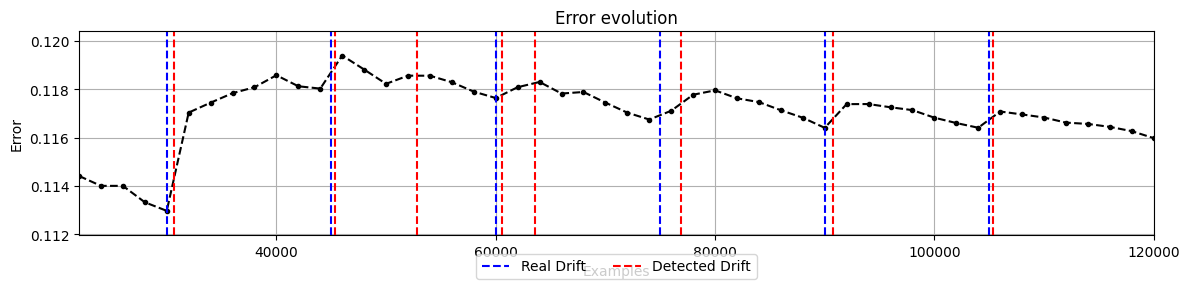

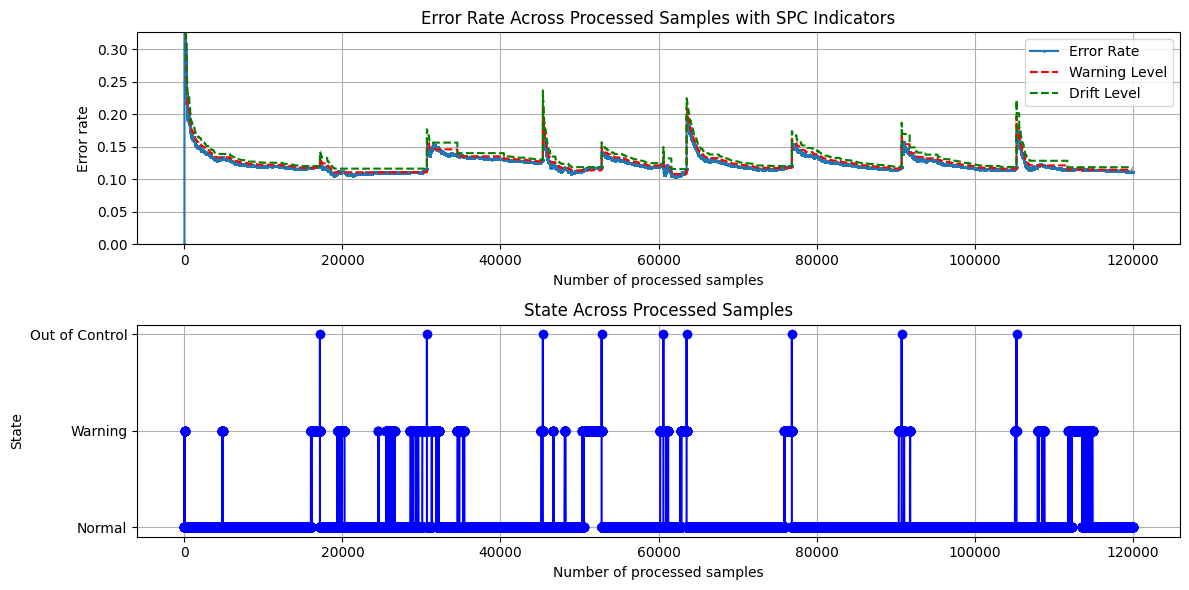

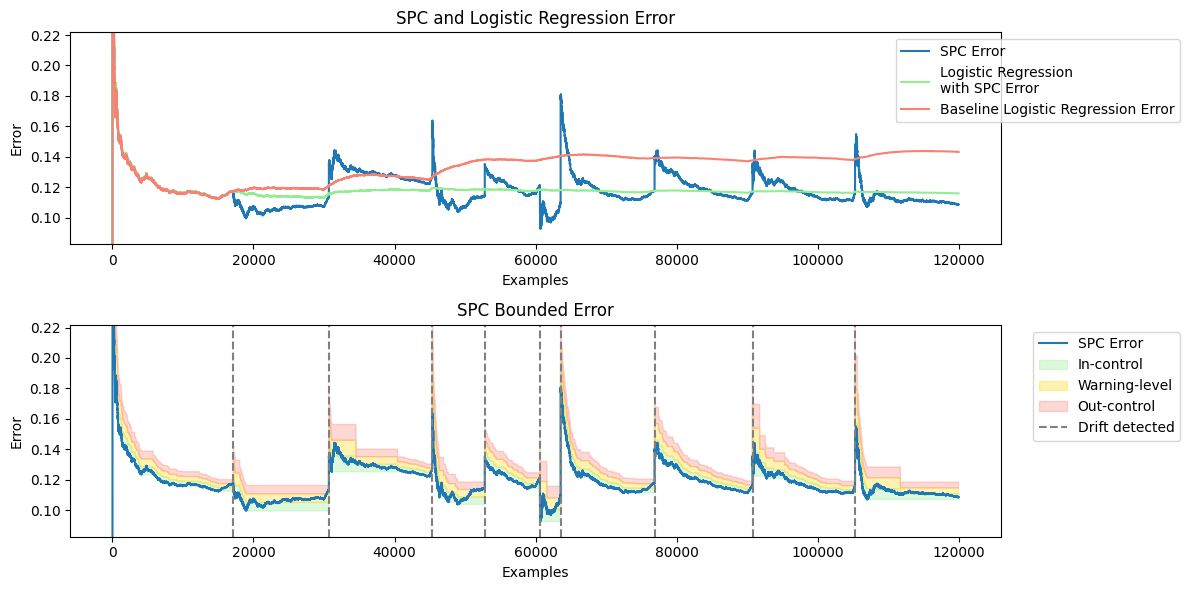

In [13]:
model = init_estimator_SGDClassifier()

spc_detector = SPCAlgorithm(init_estimator_SGDClassifier)
spc_detector, E, N = control_loop(spc_detector, report=2000)

baseline = baseline_learning(model, data_stream)
error_analysis_plot(spc_detector, baseline, N, E, "Logistic Regression")

time_diff_plot(spc_detector)

#### 4.1.3 - MLP Classifier:

In [10]:
def init_estimator_MLP():
    model = preprocessing.StandardScaler()
    model |= compat.convert_sklearn_to_river(
        estimator=neural_network.MLPClassifier(
            hidden_layer_sizes=(),
            activation='identity',
            solver='sgd',
            learning_rate_init=0.00025,
            learning_rate='constant',
            alpha=0.0001, # Strength of the L2 regularization term (divided by sample size)
            max_iter=1,
            random_state=42
        ),
        classes=[False, True]
    )
    return model

Error after 2000 samples = 27.55%
Error after 4000 samples = 20.7%
Error after 6000 samples = 17.78%
Error after 8000 samples = 15.74%
Error after 10000 samples = 14.81%
Error after 12000 samples = 14.37%
Error after 14000 samples = 13.66%
Error after 16000 samples = 13.49%
Error after 18000 samples = 13.47%
Error after 20000 samples = 13.34%
Error after 22000 samples = 13.09%
Error after 24000 samples = 12.94%
Error after 26000 samples = 12.82%
Error after 28000 samples = 12.66%
Error after 30000 samples = 12.53%
Num examples post retraining =  923
Num negatives post retraining =  320
Error after 32000 samples = 13.32%
Error after 34000 samples = 13.74%
Error after 36000 samples = 13.71%
Error after 38000 samples = 13.6%
Error after 40000 samples = 13.54%
Error after 42000 samples = 13.39%
Error after 44000 samples = 13.3%
Num examples post retraining =  337
Num negatives post retraining =  128
Error after 46000 samples = 13.65%
Error after 48000 samples = 14.02%
Error after 50000 sam

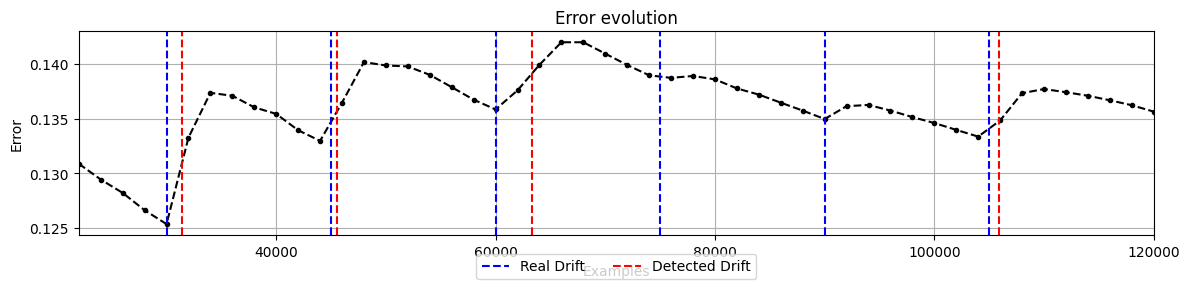

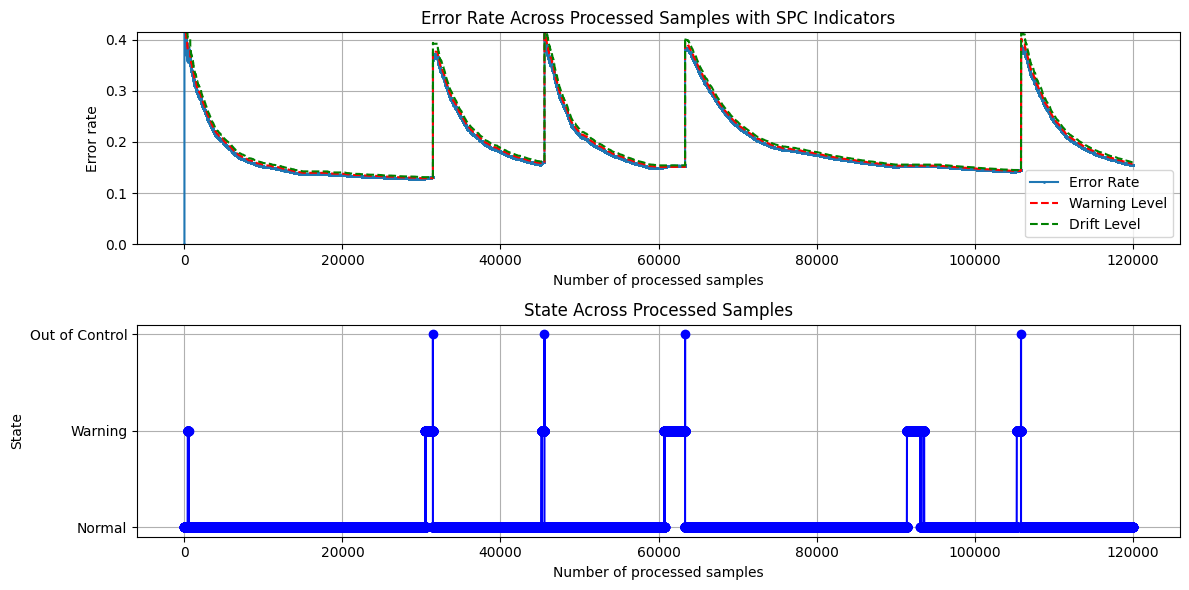

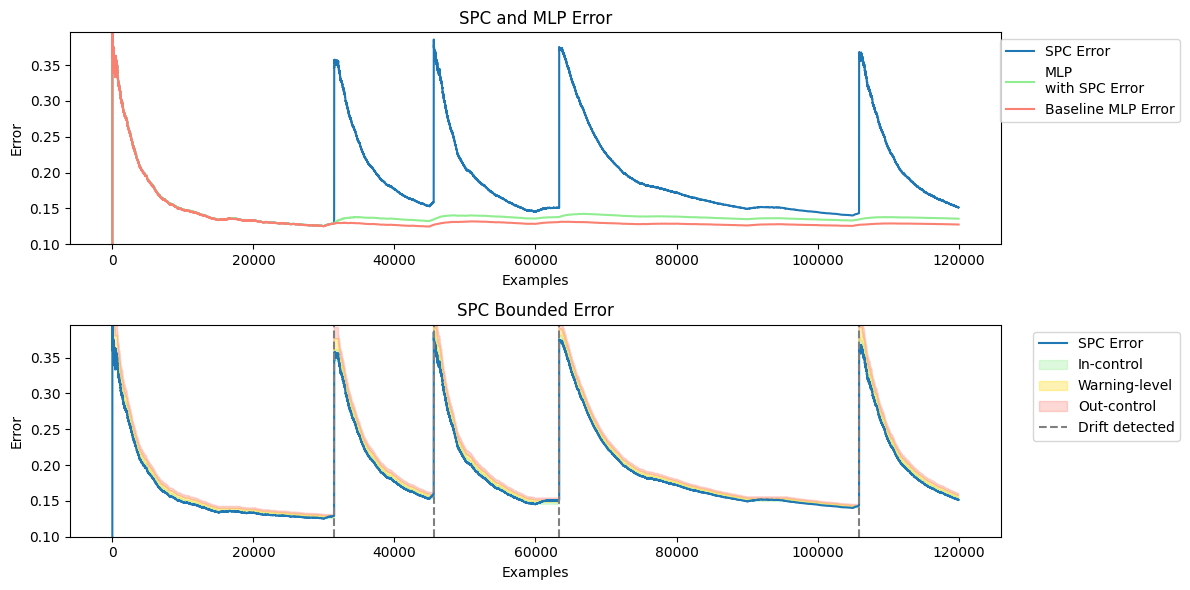

In [11]:
# with standard scaler, lr 0.00025
model = init_estimator_MLP()

spc_detector = SPCAlgorithm(init_estimator_MLP)
spc_detector, E, N = control_loop(spc_detector, report=2000)

baseline = baseline_learning(model, data_stream)
error_analysis_plot(spc_detector, baseline, N, E, "MLP")

time_diff_plot(spc_detector)

In [16]:
[i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2]

[31448, 45565, 63361, 105878]

<a id='fading'></a>
### 4.2 - Exponential smoothing SPC:

Exponential smootinhg the error

#### 4.2.1 - Fading factor = 0.99:

Error after 2000 samples = 13.55%
Error after 4000 samples = 12.52%
Error after 6000 samples = 12.72%
Error after 8000 samples = 12.32%
Error after 10000 samples = 12.36%
Error after 12000 samples = 12.51%
Error after 14000 samples = 12.24%
Error after 16000 samples = 12.45%
Num examples post retraining =  673
Num negatives post retraining =  93
Error after 18000 samples = 12.57%
Error after 20000 samples = 12.58%
Error after 22000 samples = 12.49%
Error after 24000 samples = 12.45%
Error after 26000 samples = 12.48%
Error after 28000 samples = 12.45%
Error after 30000 samples = 12.46%
Num examples post retraining =  1130
Num negatives post retraining =  133
Error after 32000 samples = 12.86%
Error after 34000 samples = 12.79%
Error after 36000 samples = 12.76%
Error after 38000 samples = 12.75%
Error after 40000 samples = 12.78%
Error after 42000 samples = 12.74%
Error after 44000 samples = 12.73%
Error after 46000 samples = 13.14%
Num examples post retraining =  921
Num negatives pos

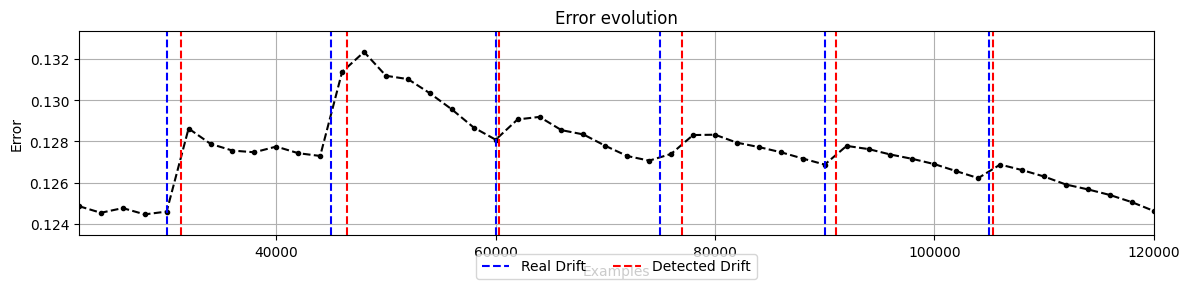

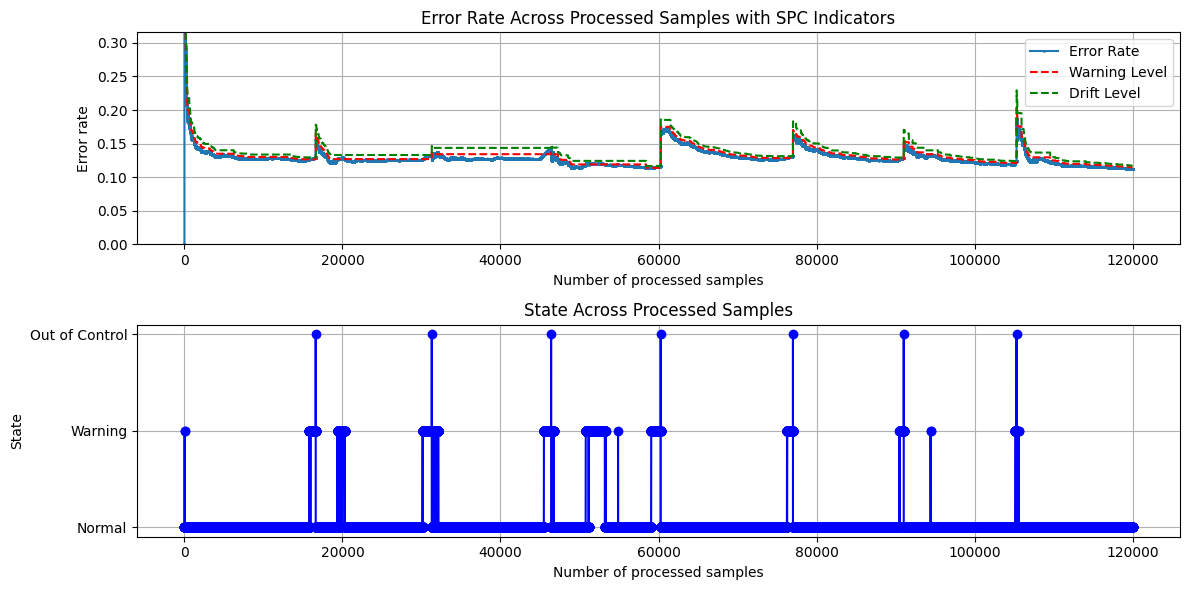

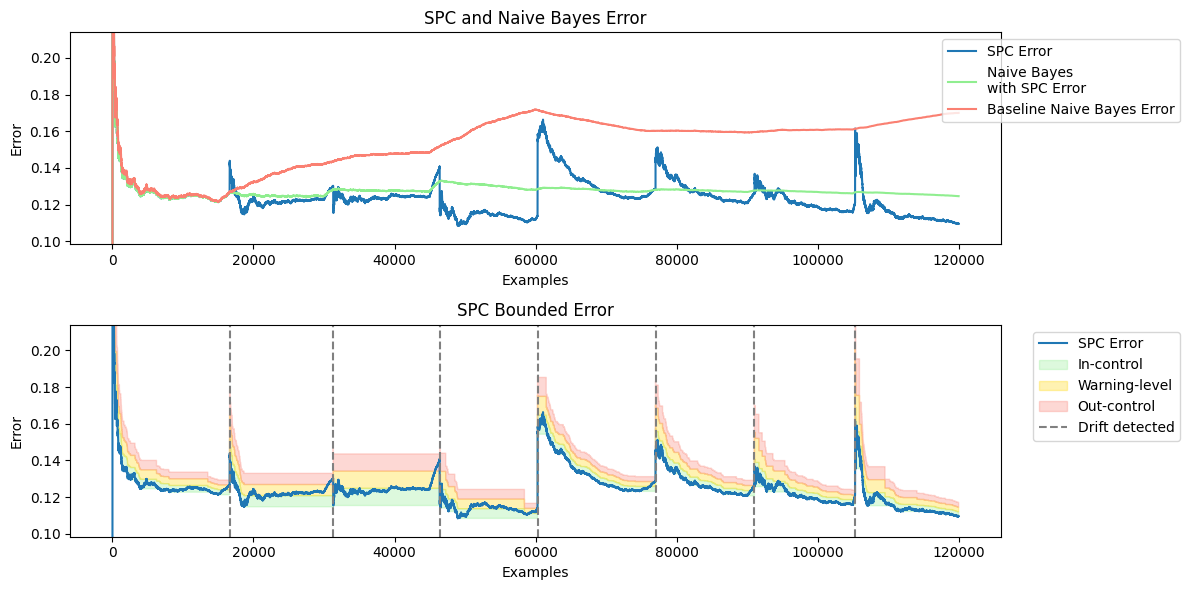

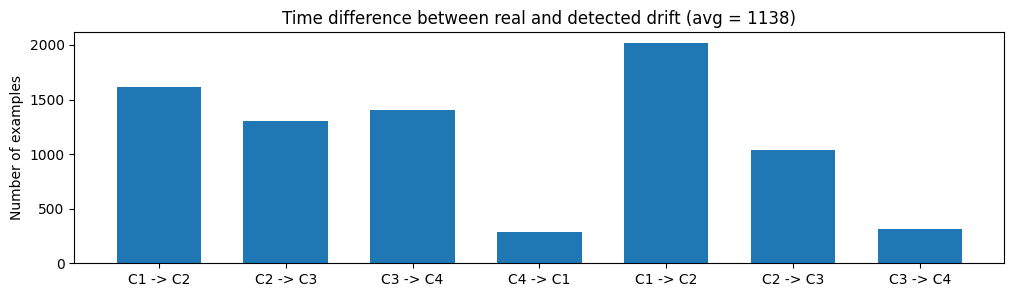

In [17]:
model = init_estimator_GaussianNB()

spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
spc_detector, E, N = control_loop(spc_detector, report=2000, exponential=True, alpha=0.99)

#baseline = baseline_learning(model, data_stream)
baseline = np.load('StandardNaiveBayesError.npy')
error_analysis_plot(spc_detector, baseline, N, E, "Naive Bayes")

time_diff_plot(spc_detector)

#### 4.2.1 - Fading factor = 0.95:

Error after 2000 samples = 13.6%
Error after 4000 samples = 12.55%
Error after 6000 samples = 12.73%
Error after 8000 samples = 12.34%
Error after 10000 samples = 12.37%
Error after 12000 samples = 12.52%
Error after 14000 samples = 12.24%
Error after 16000 samples = 12.46%
Num examples post retraining =  670
Num negatives post retraining =  93
Error after 18000 samples = 12.57%
Error after 20000 samples = 12.58%
Error after 22000 samples = 12.49%
Error after 24000 samples = 12.47%
Error after 26000 samples = 12.5%
Error after 28000 samples = 12.47%
Error after 30000 samples = 12.49%
Num examples post retraining =  1140
Num negatives post retraining =  133
Error after 32000 samples = 12.89%
Error after 34000 samples = 12.82%
Error after 36000 samples = 12.78%
Error after 38000 samples = 12.78%
Error after 40000 samples = 12.8%
Error after 42000 samples = 12.77%
Error after 44000 samples = 12.76%
Error after 46000 samples = 13.17%
Num examples post retraining =  930
Num negatives post r

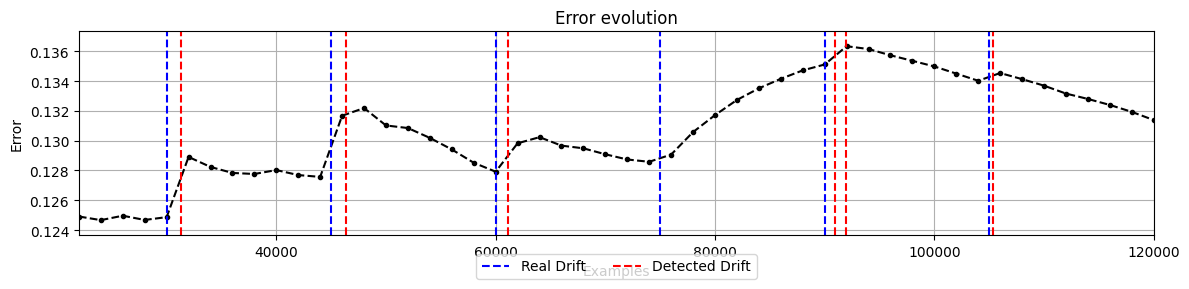

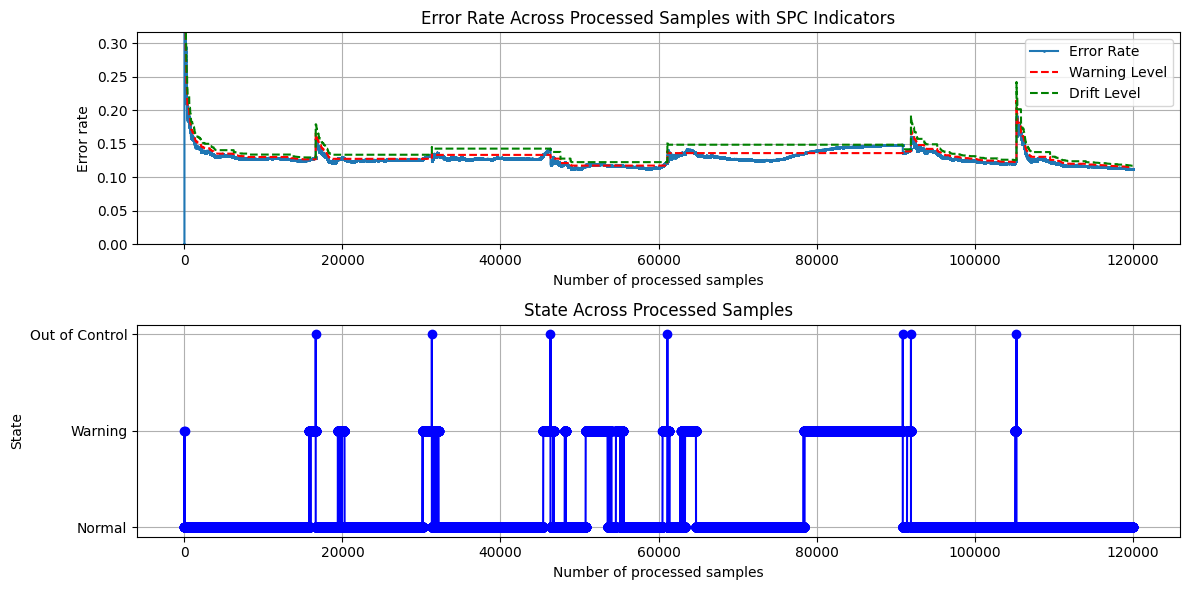

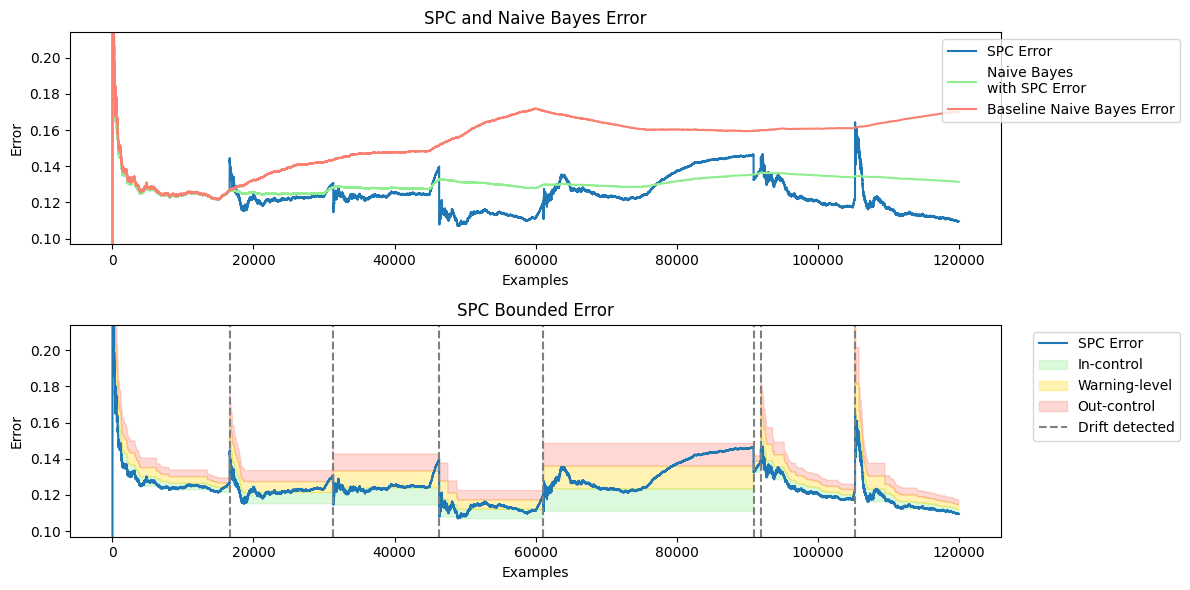

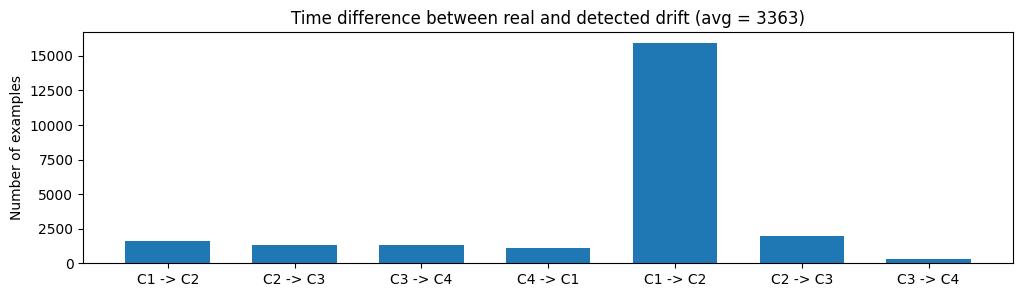

In [18]:
model = init_estimator_GaussianNB()

spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
spc_detector, E, N = control_loop(spc_detector, report=2000, exponential=True, alpha=0.95)

#baseline = baseline_learning(model, data_stream)
baseline = np.load('StandardNaiveBayesError.npy')
error_analysis_plot(spc_detector, baseline, N, E, "Naive Bayes")

time_diff_plot(spc_detector)

In [19]:
[i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2]

[16614, 31313, 46329, 61120, 90915, 91950, 105305]

#### 4.2.1 - Fading factor = 0.925:

Error after 2000 samples = 13.85%
Error after 4000 samples = 12.72%
Error after 6000 samples = 12.85%
Error after 8000 samples = 12.42%
Error after 10000 samples = 12.44%
Error after 12000 samples = 12.58%
Error after 14000 samples = 12.29%
Error after 16000 samples = 12.5%
Num examples post retraining =  684
Num negatives post retraining =  101
Error after 18000 samples = 12.61%
Error after 20000 samples = 12.61%
Error after 22000 samples = 12.52%
Error after 24000 samples = 12.49%
Error after 26000 samples = 12.51%
Error after 28000 samples = 12.48%
Error after 30000 samples = 12.5%
Num examples post retraining =  1235
Num negatives post retraining =  155
Error after 32000 samples = 12.95%
Error after 34000 samples = 12.87%
Error after 36000 samples = 12.83%
Error after 38000 samples = 12.82%
Error after 40000 samples = 12.85%
Error after 42000 samples = 12.82%
Error after 44000 samples = 12.81%
Num examples post retraining =  338
Num negatives post retraining =  42
Error after 46000

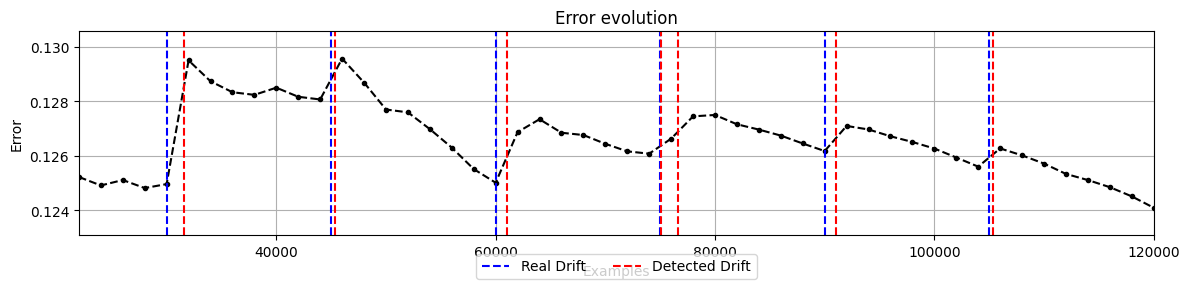

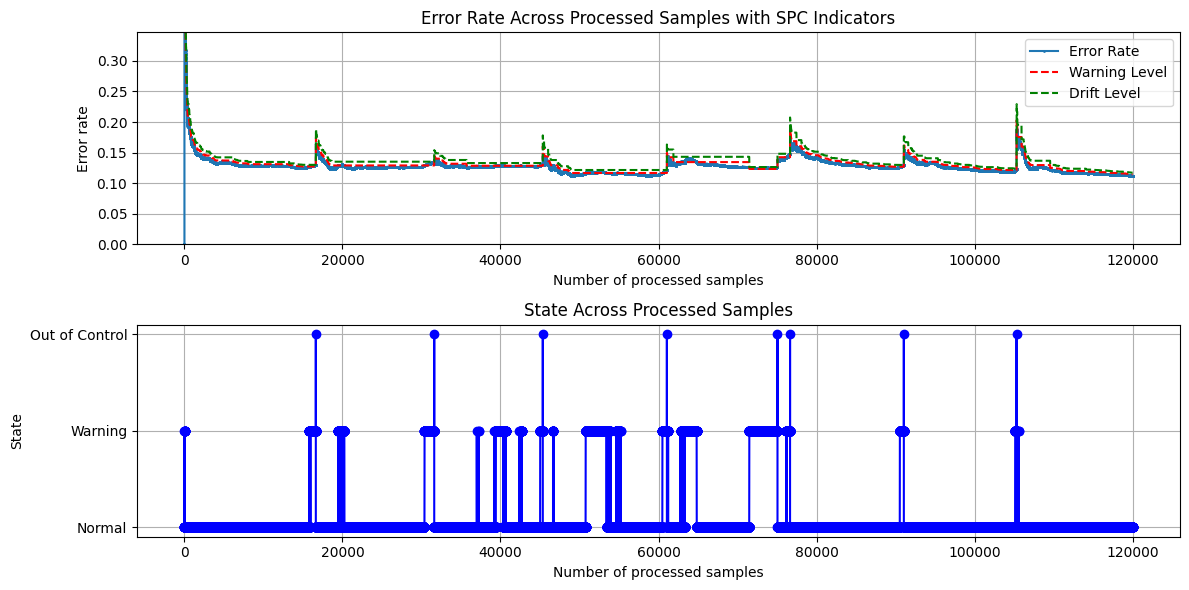

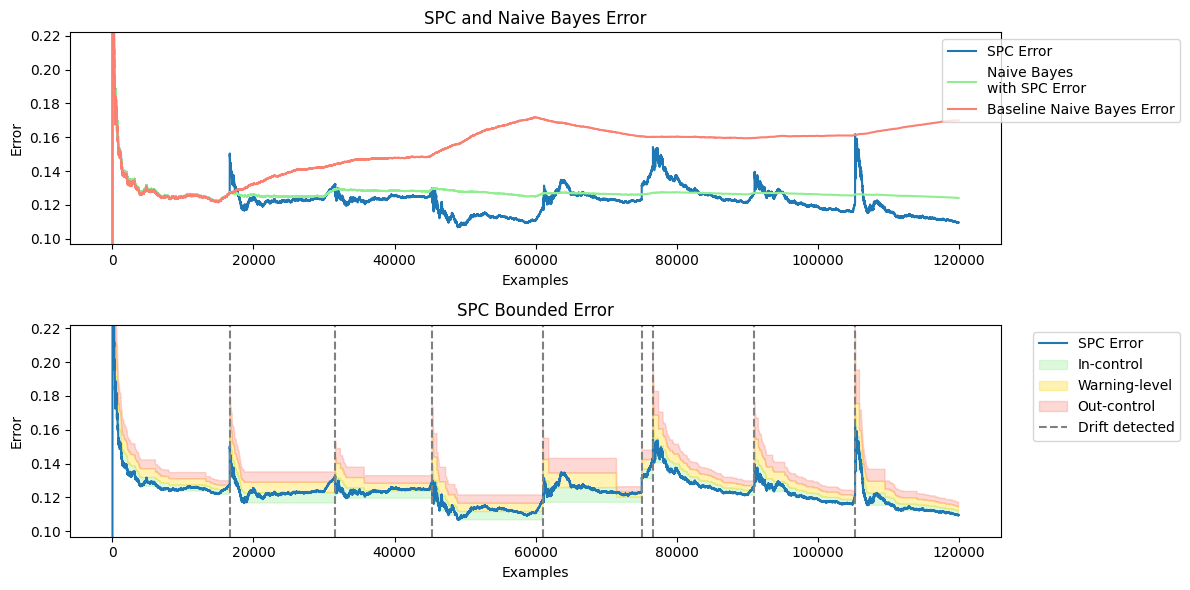

In [20]:
model = init_estimator_GaussianNB()

spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
spc_detector, E, N = control_loop(spc_detector, report=2000, exponential=True, alpha=0.925)

#baseline = baseline_learning(model, data_stream)
baseline = np.load('StandardNaiveBayesError.npy')
error_analysis_plot(spc_detector, baseline, N, E, "Naive Bayes")

time_diff_plot(spc_detector)

In [21]:
[i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2]

[16628, 31614, 45355, 61059, 75057, 76647, 91048, 105313]

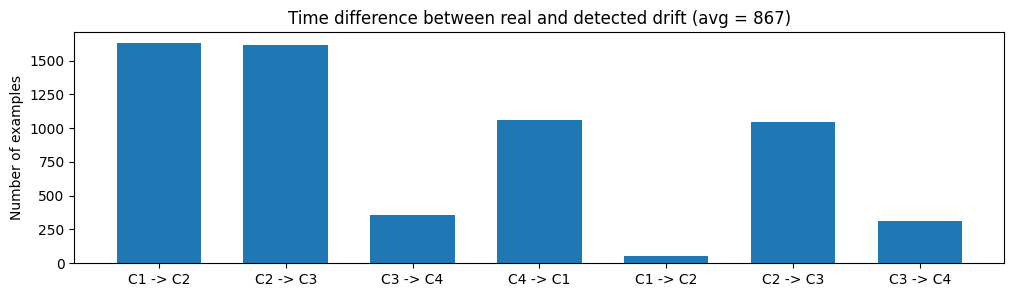

In [22]:
to_print = spc_detector
to_print.states[76647] = 0
time_diff_plot(to_print)

<a id='window'></a>
### 4.3 - Sliding window strategy to update the error:

Error after 2000 samples = 13.55%
Error after 4000 samples = 12.52%
Error after 6000 samples = 12.72%
Error after 8000 samples = 12.32%
Error after 10000 samples = 12.36%
Error after 12000 samples = 12.51%
Error after 14000 samples = 12.23%
Error after 16000 samples = 12.44%
Num examples post retraining =  762
Num negatives post retraining =  102
Error after 18000 samples = 12.43%
Error after 20000 samples = 12.46%
Error after 22000 samples = 12.39%
Error after 24000 samples = 12.38%
Error after 26000 samples = 12.42%
Error after 28000 samples = 12.4%
Error after 30000 samples = 12.43%
Num examples post retraining =  768
Num negatives post retraining =  134
Error after 32000 samples = 12.56%
Error after 34000 samples = 12.47%
Error after 36000 samples = 12.4%
Error after 38000 samples = 12.38%
Error after 40000 samples = 12.41%
Error after 42000 samples = 12.37%
Num examples post retraining =  1643
Num negatives post retraining =  198
Error after 44000 samples = 12.37%
Num examples pos

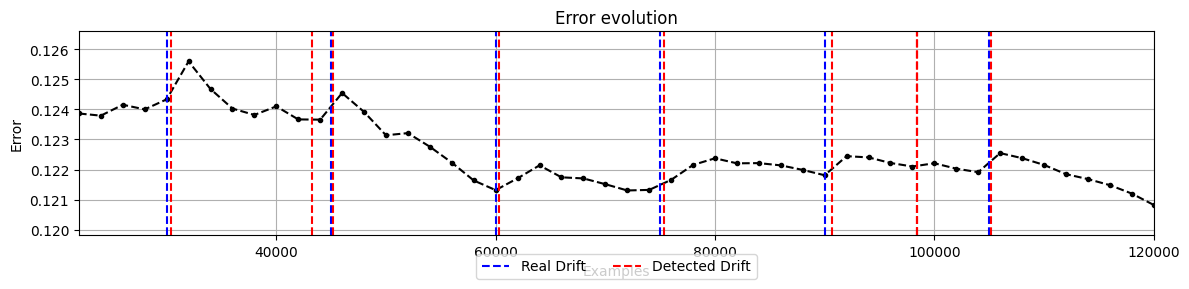

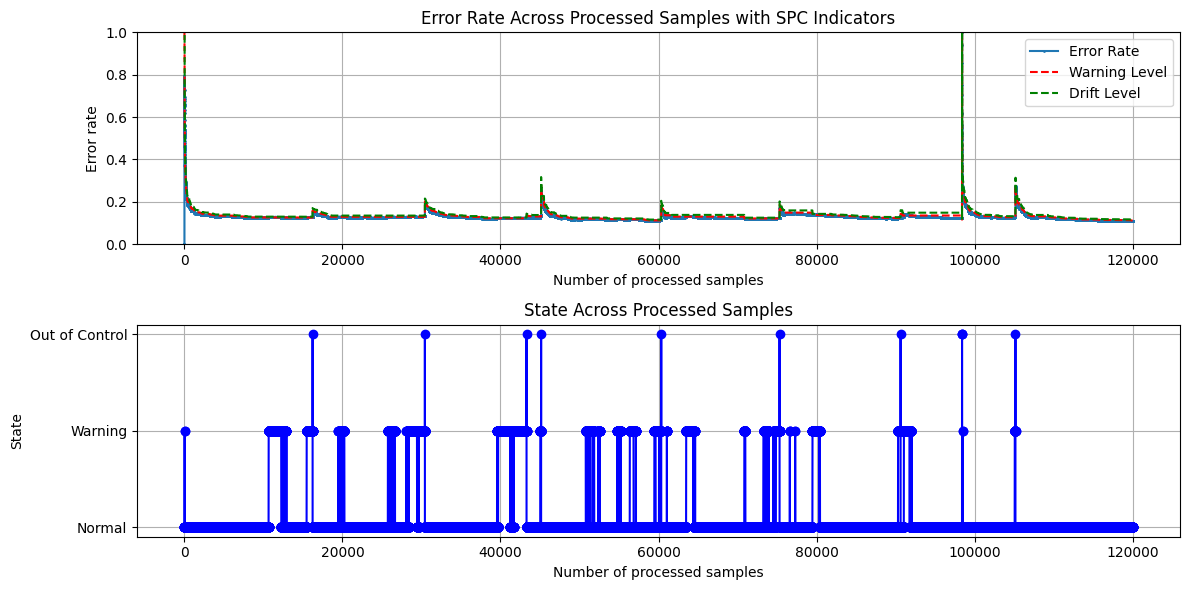

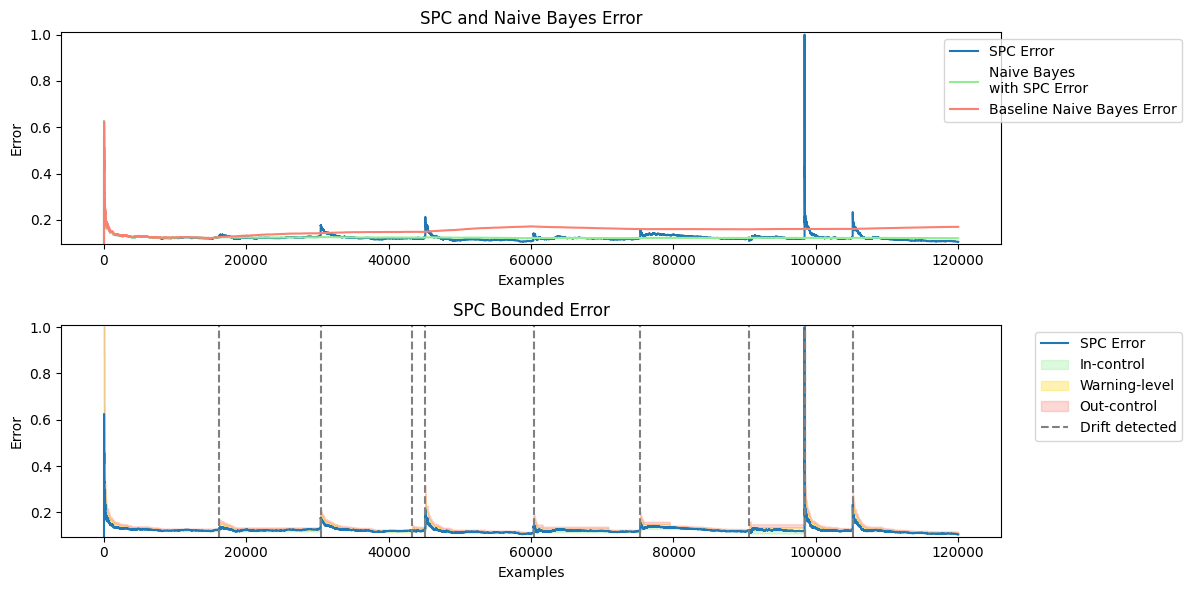

In [13]:
model = init_estimator_GaussianNB()

spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
spc_detector, E, N = control_loop(spc_detector, report=2000, sliding_window=True, window_size=7500)

#baseline = baseline_learning(model, data_stream)
error_analysis_plot(spc_detector, baseline, N, E, "Naive Bayes")

time_diff_plot(spc_detector)

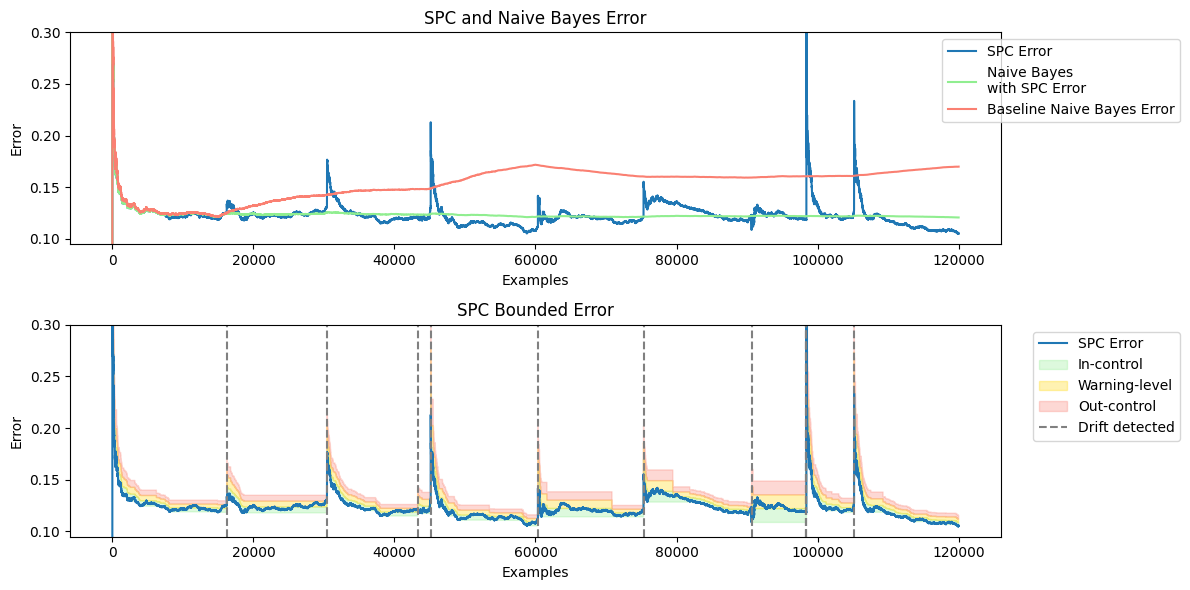

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
model_name = 'Naive Bayes'
ax1.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
ax1.plot(N[1:], np.array(E[1:])/np.array(N[1:]), color='lightgreen', label=f"{model_name}\nwith SPC Error")
ax1.plot(N[1:], baseline, color='salmon', label=f"Baseline {model_name} Error")

lower_bound = min(min(min(spc_detector.ps[5:]), min(baseline[5:]), min((np.array(E[1:])/np.array(N[1:]))[5:])) - 0.01, 0.1)
upper_bound = max(max(max(spc_detector.ps[250:]), max(baseline[250:]), max((np.array(E[1:])/np.array(N[1:]))[250:])) + 0.01, 0.2)

ax2.plot(N[1:], np.array(spc_detector.ps), label='SPC Error')
#ax2.plot(N[1:], np.array(spc_detector.ps) + np.array(spc_detector.ss), label='SPC Error - boundary', linestyle='dashed', color='C0')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins), np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                alpha=0.3, color='lightgreen', label='In-control')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins), alpha=0.3, color='gold', label='Warning-level')
ax2.fill_between(N[1:], np.array(spc_detector.Pmins) + 2*np.array(spc_detector.Smins),
                        np.array(spc_detector.Pmins) + 3*np.array(spc_detector.Smins), alpha=0.3, color='salmon', label='Out-control')
ax2.vlines([i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2], ymin=lower_bound, ymax=upper_bound,
        color='grey', linestyles='dashed', label='Drift detected')

ax1.set_ylim(lower_bound, 0.3)
ax2.set_ylim(lower_bound, 0.3)
ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax1.set_title(f"SPC and {model_name} Error")
ax2.set_title('SPC Bounded Error')
ax1.set_xlabel('Examples')
ax2.set_xlabel('Examples')
ax1.set_ylabel('Error')
ax2.set_ylabel('Error')
plt.tight_layout()
plt.show()

In [14]:
[i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2]

[16221, 30432, 43297, 45141, 60344, 75320, 90637, 98412, 98413, 98414, 105172]

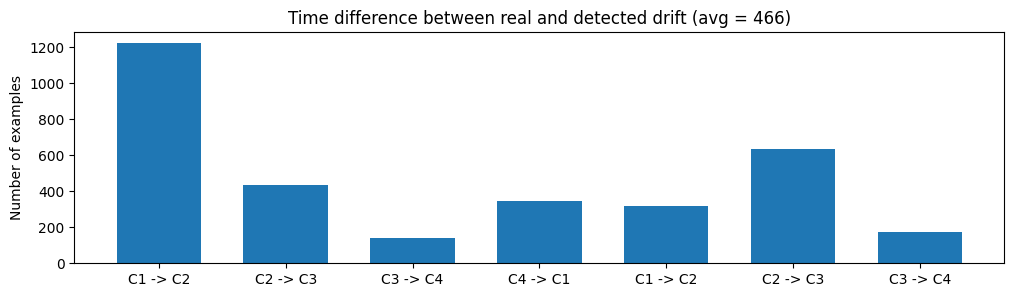

In [15]:
to_print = spc_detector
to_print.states[43297] = 0
to_print.states[98412] = 0
to_print.states[98413] = 0
to_print.states[98414] = 0
time_diff_plot(to_print)

Error after 2000 samples = 13.55%
Error after 4000 samples = 12.52%
Error after 6000 samples = 12.72%
Error after 8000 samples = 12.32%
Error after 10000 samples = 12.36%
Error after 12000 samples = 12.51%
Error after 14000 samples = 12.24%
Error after 16000 samples = 12.45%
Num examples post retraining =  691
Num negatives post retraining =  91
Error after 18000 samples = 12.45%
Error after 20000 samples = 12.48%
Error after 22000 samples = 12.4%
Error after 24000 samples = 12.38%
Error after 26000 samples = 12.42%
Error after 28000 samples = 12.41%
Error after 30000 samples = 12.44%
Num examples post retraining =  381
Num negatives post retraining =  40
Num examples post retraining =  144
Num negatives post retraining =  32
Error after 32000 samples = 12.67%
Error after 34000 samples = 12.6%
Error after 36000 samples = 12.58%
Error after 38000 samples = 12.59%
Error after 40000 samples = 12.63%
Error after 42000 samples = 12.6%
Error after 44000 samples = 12.6%
Num examples post retr

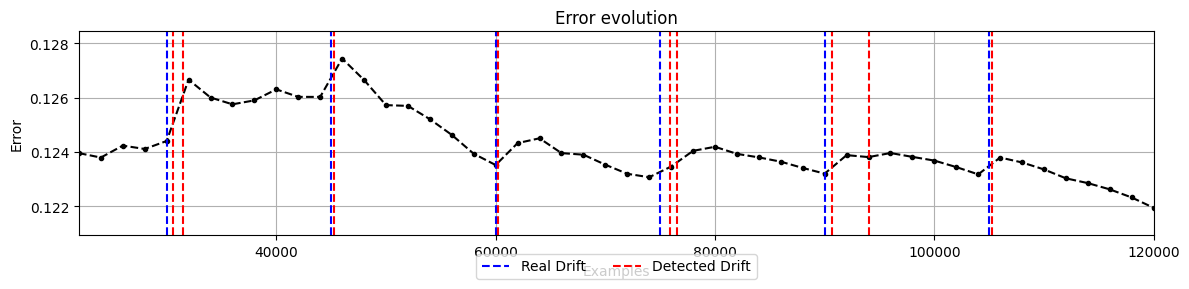

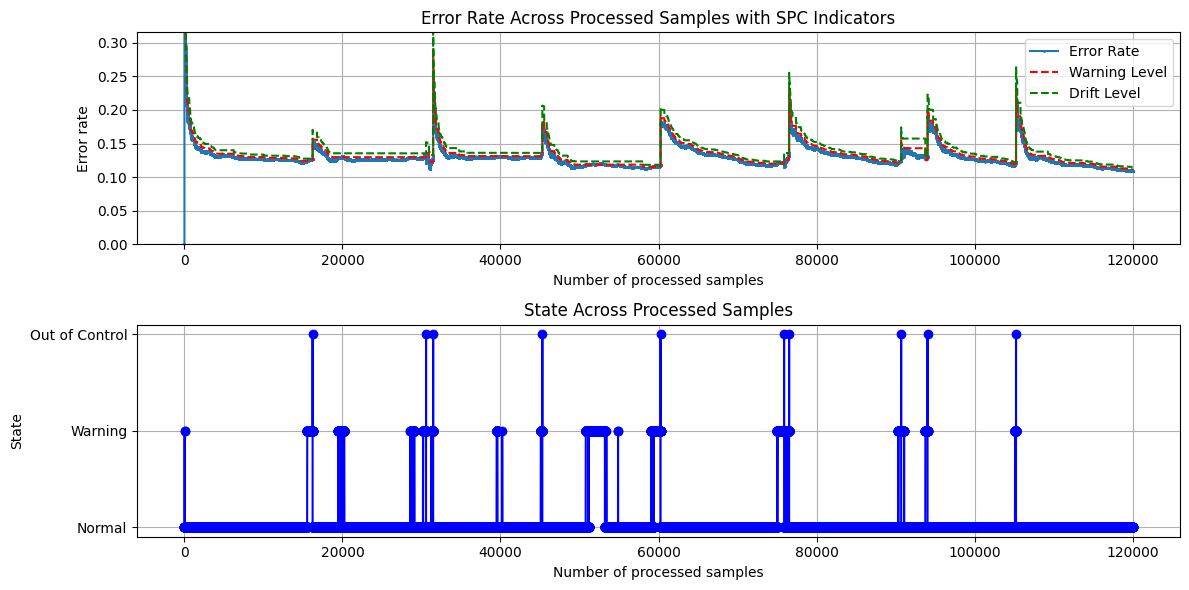

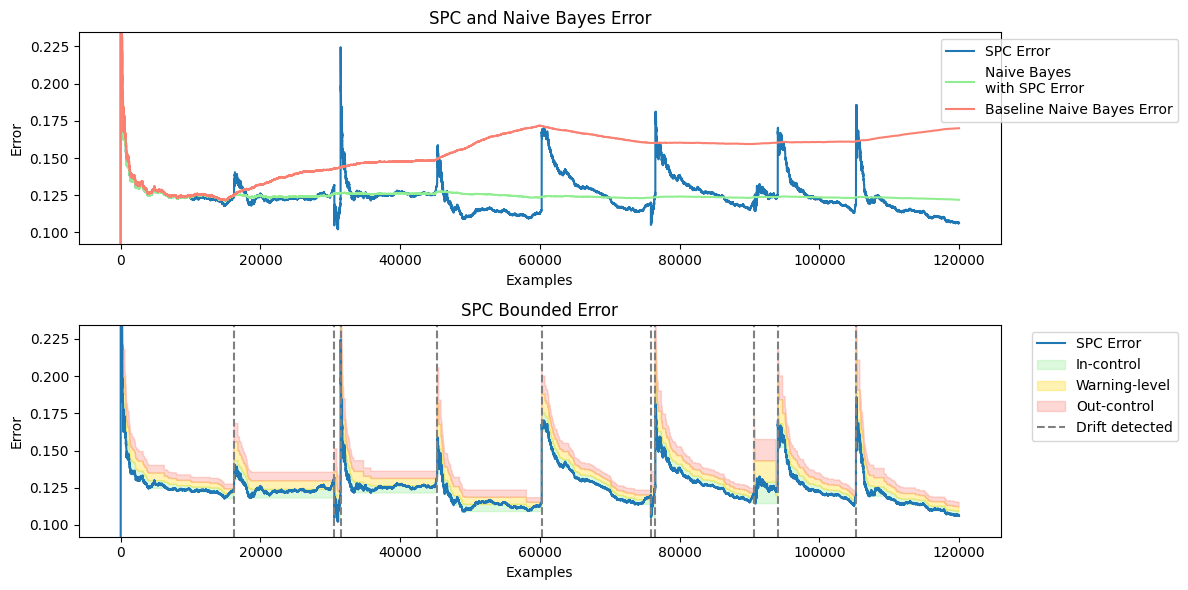

In [9]:
model = init_estimator_GaussianNB()

spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
spc_detector, E, N = control_loop(spc_detector, report=2000, sliding_window=True, window_size=10000)

baseline = baseline_learning(model, data_stream)
error_analysis_plot(spc_detector, baseline, N, E, "Naive Bayes")

time_diff_plot(spc_detector)

In [10]:
[i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2]

[16221, 30581, 31478, 45296, 60260, 75893, 76530, 90708, 94050, 105246]

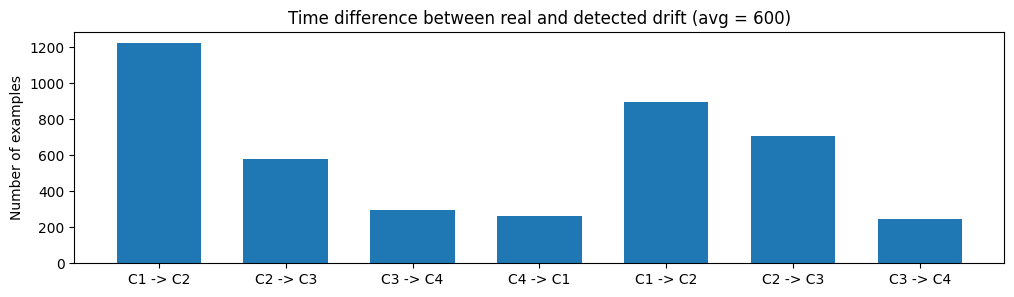

In [11]:
to_print = spc_detector
to_print.states[31478] = 0
to_print.states[76530] = 0
to_print.states[94050] = 0
time_diff_plot(to_print)

<a id='hidden'></a>
### 4.4 - Concept drift on hidden variables:

In [ ]:
! python SEAconcepts_hidden_variables.py

![SEAconcept_hidden_variables.png](attachment:SEAconcept_hidden_variables.png)

In [21]:
# import data
PATH = os.path.dirname(os.path.abspath('__file__'))
data_stream = pd.read_csv(f"{PATH}/data/SEAconcepts_hidden_variables.csv")

In [25]:
model = init_estimator_GaussianNB()
baseline = baseline_learning(model, data_stream)
np.save('StandardNaiveBayes_hidden_variables.npy', baseline)

Num examples post retraining =  1
Num negatives post retraining =  1
Error after 2000 samples = 17.9%
Error after 4000 samples = 19.5%
Error after 6000 samples = 19.62%
Error after 8000 samples = 20.1%
Error after 10000 samples = 20.04%
Error after 12000 samples = 19.91%
Error after 14000 samples = 19.99%
Error after 16000 samples = 20.06%
Error after 18000 samples = 20.31%
Error after 20000 samples = 20.41%
Error after 22000 samples = 20.55%
Error after 24000 samples = 20.62%
Error after 26000 samples = 20.65%
Error after 28000 samples = 20.57%
Error after 30000 samples = 20.61%
Error after 32000 samples = 20.71%
Error after 34000 samples = 20.77%
Error after 36000 samples = 20.79%
Error after 38000 samples = 20.82%
Error after 40000 samples = 20.89%
Error after 42000 samples = 20.83%
Error after 44000 samples = 20.92%
Error after 46000 samples = 21.06%
Error after 48000 samples = 21.32%
Num examples post retraining =  43821
Num negatives post retraining =  9539
Error after 50000 samp

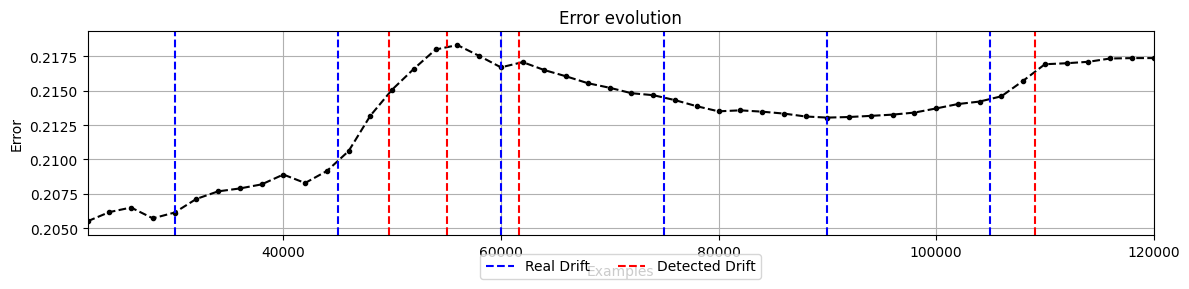

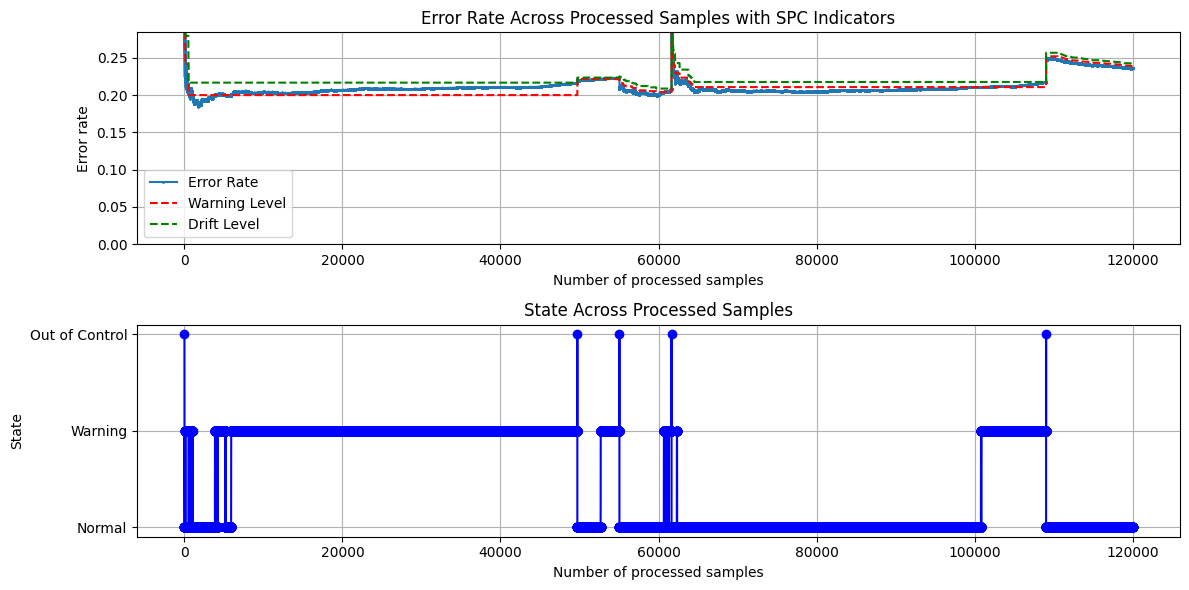

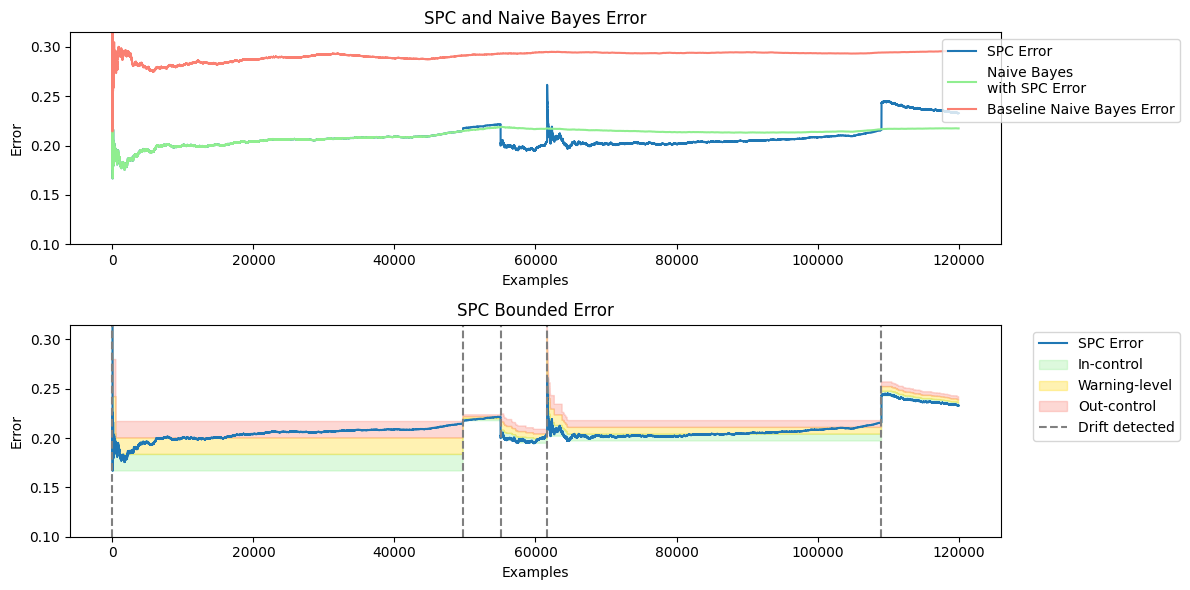

In [26]:
spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
spc_detector, E, N = control_loop(spc_detector, report=2000)
baseline = np.load('StandardNaiveBayesError_hidden.npy')
error_analysis_plot(spc_detector, baseline, N, E, "Naive Bayes")

Num examples post retraining =  1
Num negatives post retraining =  1
Error after 2000 samples = 17.85%
Error after 4000 samples = 19.42%
Error after 6000 samples = 19.57%
Num examples post retraining =  3151
Num negatives post retraining =  650
Error after 8000 samples = 20.05%
Error after 10000 samples = 20.0%
Error after 12000 samples = 19.85%
Error after 14000 samples = 19.92%
Error after 16000 samples = 20.0%
Error after 18000 samples = 20.24%
Error after 20000 samples = 20.33%
Error after 22000 samples = 20.47%
Error after 24000 samples = 20.54%
Error after 26000 samples = 20.58%
Error after 28000 samples = 20.51%
Error after 30000 samples = 20.56%
Error after 32000 samples = 20.68%
Error after 34000 samples = 20.74%
Num examples post retraining =  15583
Num negatives post retraining =  3349
Error after 36000 samples = 20.77%
Error after 38000 samples = 20.8%
Error after 40000 samples = 20.86%
Error after 42000 samples = 20.81%
Error after 44000 samples = 20.88%
Error after 46000 

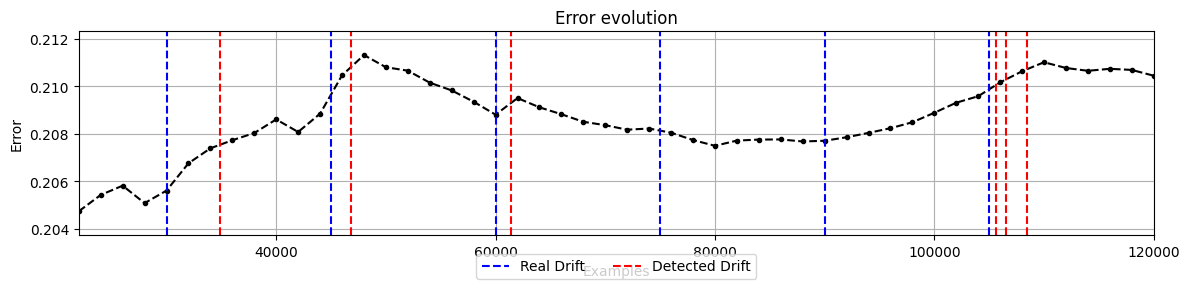

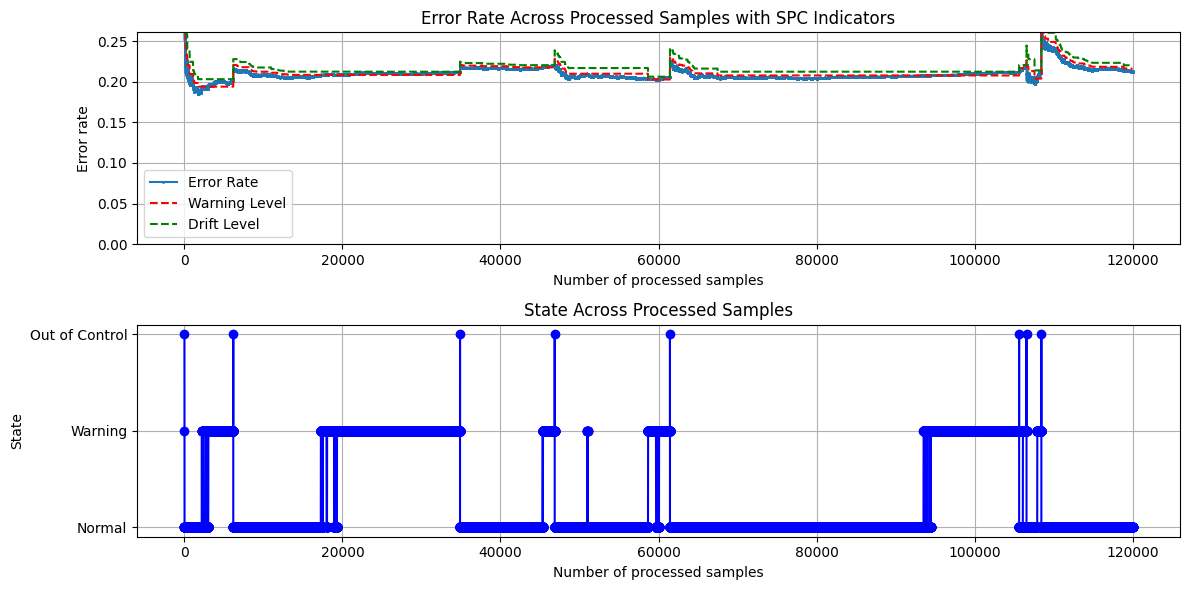

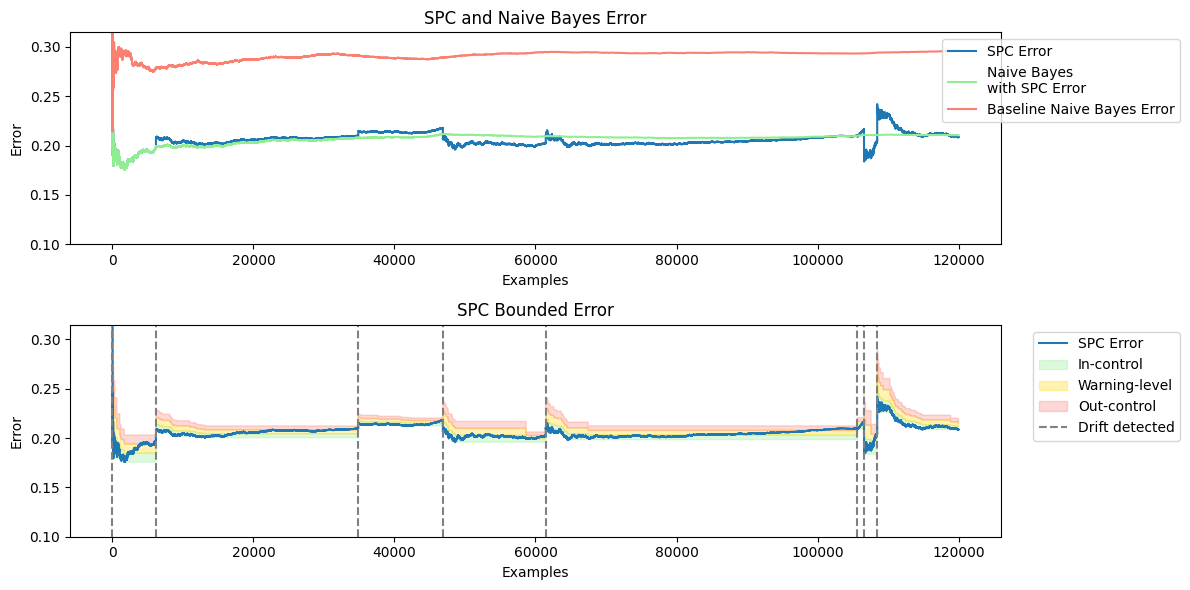

In [27]:
spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
spc_detector, E, N = control_loop(spc_detector, report=2000, exponential=True, alpha=0.91)
baseline = np.load('StandardNaiveBayesError_hidden.npy')
error_analysis_plot(spc_detector, baseline, N, E, "Naive Bayes")

In [28]:
[i for i in range(len(spc_detector.states)) if spc_detector.states[i] == 2]

[0, 6180, 34880, 46861, 61449, 105639, 106576, 108452]

Num examples post retraining =  1
Num negatives post retraining =  1
Error after 2000 samples = 17.9%
Error after 4000 samples = 19.5%
Error after 6000 samples = 19.62%
Error after 8000 samples = 20.1%
Error after 10000 samples = 20.04%
Error after 12000 samples = 19.91%
Error after 14000 samples = 19.99%
Error after 16000 samples = 20.06%
Error after 18000 samples = 20.31%
Error after 20000 samples = 20.41%
Num examples post retraining =  10000
Num negatives post retraining =  2086
Error after 22000 samples = 20.55%
Error after 24000 samples = 20.59%
Error after 26000 samples = 20.59%
Error after 28000 samples = 20.52%
Error after 30000 samples = 20.57%
Error after 32000 samples = 20.68%
Error after 34000 samples = 20.76%
Num examples post retraining =  1207
Num negatives post retraining =  233
Error after 36000 samples = 20.71%
Error after 38000 samples = 20.68%
Error after 40000 samples = 20.66%
Error after 42000 samples = 20.59%
Num examples post retraining =  229
Num negatives pos

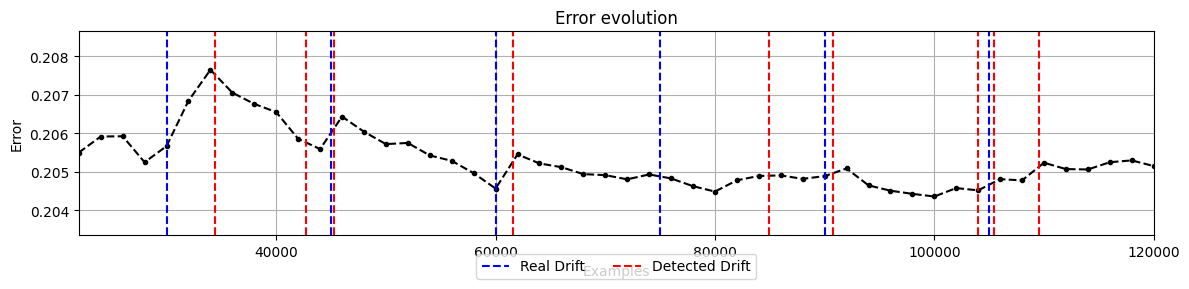

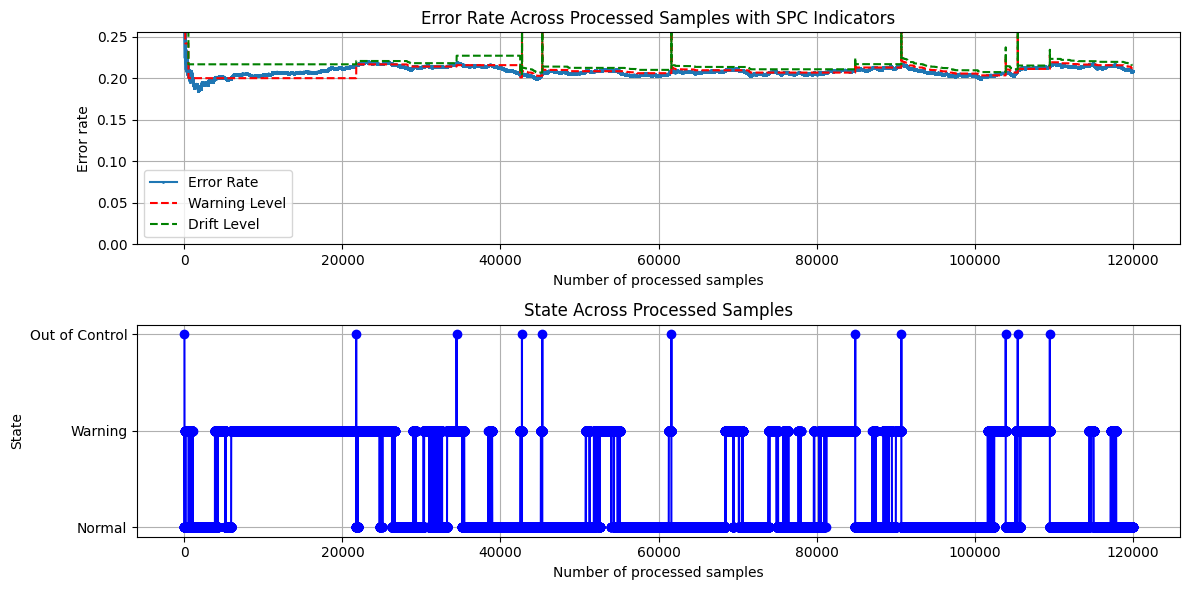

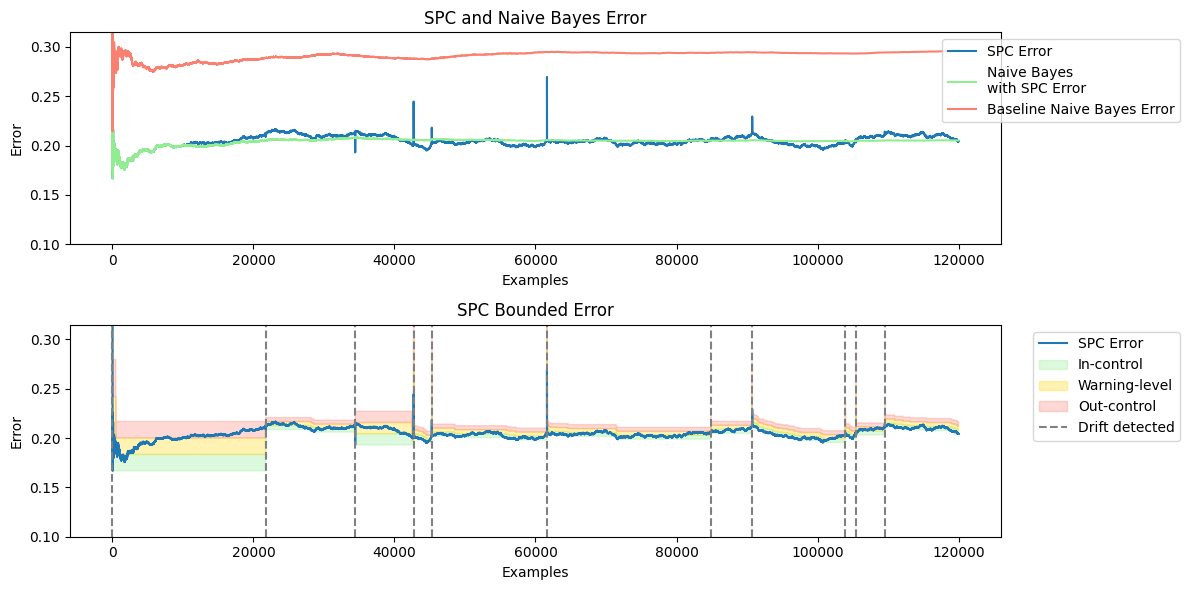

In [29]:
spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
spc_detector, E, N = control_loop(spc_detector, report=2000, sliding_window=True, window_size=10000)
baseline = np.load('StandardNaiveBayesError_hidden.npy')
error_analysis_plot(spc_detector, baseline, N, E, "Naive Bayes")

Num examples post retraining =  1
Num negatives post retraining =  1
Error after 2000 samples = 17.9%
Error after 4000 samples = 19.5%
Error after 6000 samples = 19.62%
Error after 8000 samples = 20.1%
Error after 10000 samples = 20.04%
Error after 12000 samples = 19.91%
Error after 14000 samples = 19.99%
Error after 16000 samples = 20.06%
Error after 18000 samples = 20.31%
Num examples post retraining =  7500
Num negatives post retraining =  1525
Error after 20000 samples = 20.4%
Error after 22000 samples = 20.5%
Num examples post retraining =  514
Num negatives post retraining =  109
Error after 24000 samples = 20.54%
Error after 26000 samples = 20.53%
Error after 28000 samples = 20.37%
Error after 30000 samples = 20.38%
Num examples post retraining =  1360
Num negatives post retraining =  270
Error after 32000 samples = 20.53%
Error after 34000 samples = 20.49%
Error after 36000 samples = 20.37%
Error after 38000 samples = 20.36%
Error after 40000 samples = 20.36%
Error after 42000 

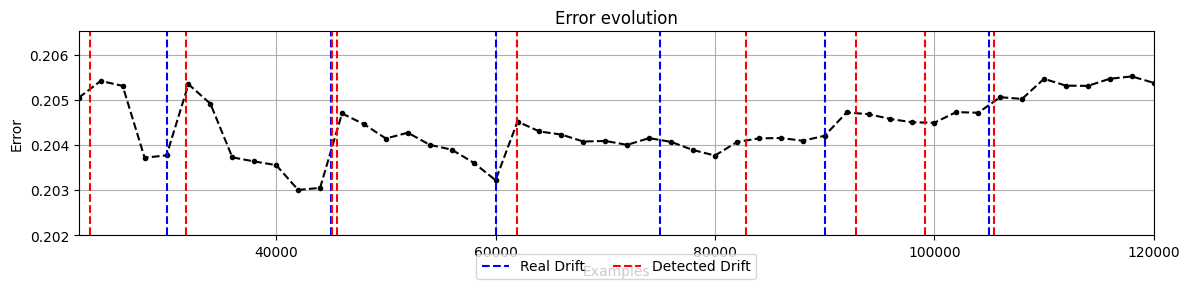

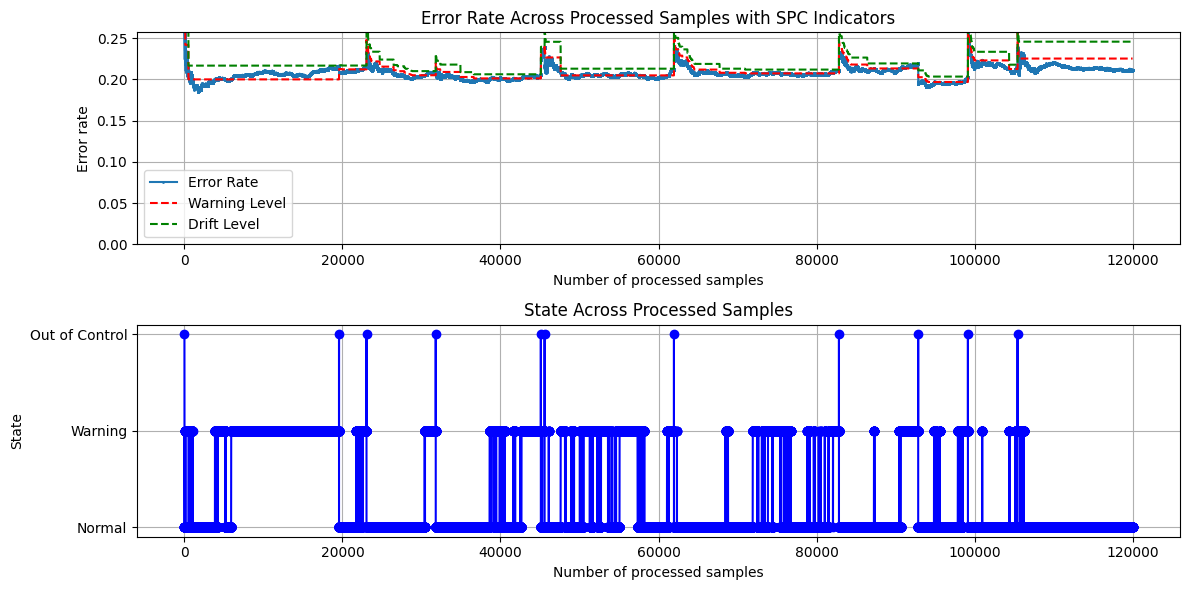

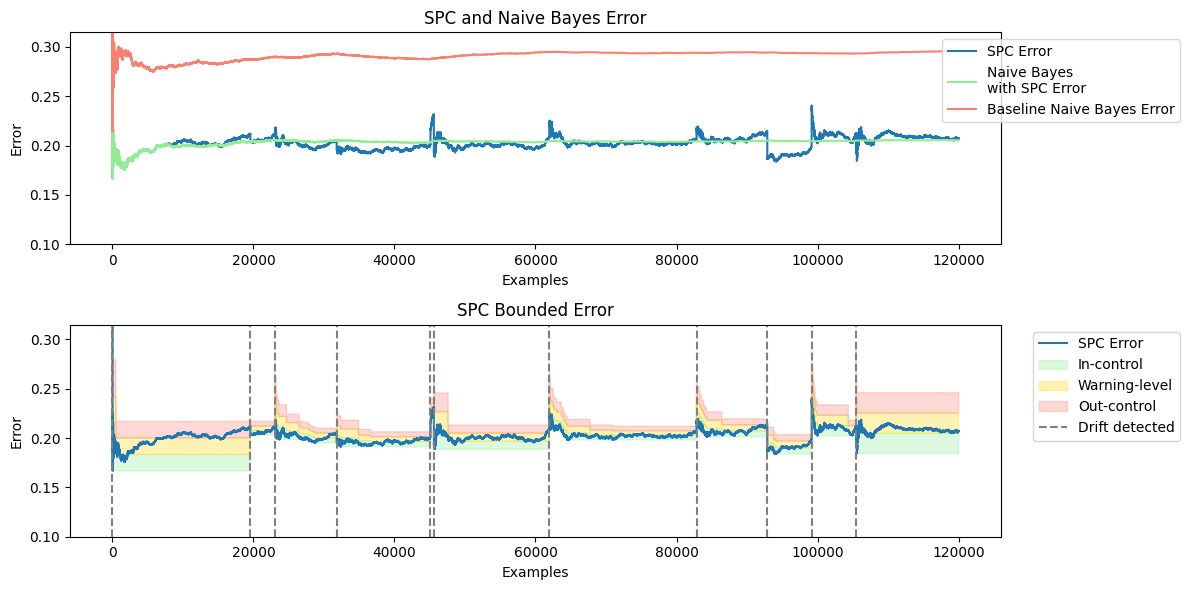

In [22]:
spc_detector = SPCAlgorithm(init_estimator_GaussianNB)
spc_detector, E, N = control_loop(spc_detector, report=2000, sliding_window=True, window_size=7500)
baseline = np.load('StandardNaiveBayesError_hidden.npy')
error_analysis_plot(spc_detector, baseline, N, E, "Naive Bayes")